In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import model_selection, metrics
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.metrics import precision_score, f1_score, accuracy_score, recall_score
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, accuracy_score, classification_report


/kaggle/input/lung-cancer/survey lung cancer.csv


In [2]:
plt.style.use("ggplot")  #seaborn-whitegrid
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'
#ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Importing dataset


In [3]:
lungs_df= pd.read_csv('/kaggle/input/lung-cancer/survey lung cancer.csv')
lungs_df

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,F,56,1,1,1,2,2,2,1,1,2,2,2,2,1,YES
305,M,70,2,1,1,1,1,2,2,2,2,2,2,1,2,YES
306,M,58,2,1,1,1,1,1,2,2,2,2,1,1,2,YES
307,M,67,2,1,2,1,1,2,2,1,2,2,2,1,2,YES


## Dataset Description

The effectiveness of cancer prediction system helps the people to know their cancer risk with low cost and it also helps the people to take the appropriate decision based on their cancer risk status. The data is collected from the website online lung cancer prediction system .

Total no. of attributes:16
No .of instances:284
Attribute information:

Gender: M(male), F(female)

Age: Age of the patient

Smoking: YES=2 , NO=1.

Yellow fingers: YES=2 , NO=1.

Anxiety: YES=2 , NO=1.

Peer_pressure: YES=2 , NO=1.

Chronic Disease: YES=2 , NO=1.

Fatigue: YES=2 , NO=1.

Allergy: YES=2 , NO=1.

Wheezing: YES=2 , NO=1.

Alcohol: YES=2 , NO=1.

Coughing: YES=2 , NO=1.

Shortness of Breath: YES=2 , NO=1.

Swallowing Difficulty: YES=2 , NO=1.

Chest pain: YES=2 , NO=1.

Lung Cancer: YES , NO.

In [4]:
lungs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309 entries, 0 to 308
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   GENDER                 309 non-null    object
 1   AGE                    309 non-null    int64 
 2   SMOKING                309 non-null    int64 
 3   YELLOW_FINGERS         309 non-null    int64 
 4   ANXIETY                309 non-null    int64 
 5   PEER_PRESSURE          309 non-null    int64 
 6   CHRONIC DISEASE        309 non-null    int64 
 7   FATIGUE                309 non-null    int64 
 8   ALLERGY                309 non-null    int64 
 9   WHEEZING               309 non-null    int64 
 10  ALCOHOL CONSUMING      309 non-null    int64 
 11  COUGHING               309 non-null    int64 
 12  SHORTNESS OF BREATH    309 non-null    int64 
 13  SWALLOWING DIFFICULTY  309 non-null    int64 
 14  CHEST PAIN             309 non-null    int64 
 15  LUNG_CANCER            

In [5]:
lungs_df.describe().T

,count,mean,std,min,25%,50%,75%,max
AGE,309.0,62.673139,8.210301,21.0,57.0,62.0,69.0,87.0
SMOKING,309.0,1.563107,0.496806,1.0,1.0,2.0,2.0,2.0
YELLOW_FINGERS,309.0,1.569579,0.495938,1.0,1.0,2.0,2.0,2.0
ANXIETY,309.0,1.498382,0.500808,1.0,1.0,1.0,2.0,2.0
PEER_PRESSURE,309.0,1.501618,0.500808,1.0,1.0,2.0,2.0,2.0
CHRONIC DISEASE,309.0,1.504854,0.500787,1.0,1.0,2.0,2.0,2.0
FATIGUE,309.0,1.673139,0.469827,1.0,1.0,2.0,2.0,2.0
ALLERGY,309.0,1.556634,0.497588,1.0,1.0,2.0,2.0,2.0
WHEEZING,309.0,1.556634,0.497588,1.0,1.0,2.0,2.0,2.0
ALCOHOL CONSUMING,309.0,1.556634,0.497588,1.0,1.0,2.0,2.0,2.0


In [6]:
lungs_df.isnull().sum()

GENDER                   0
AGE                      0
SMOKING                  0
YELLOW_FINGERS           0
ANXIETY                  0
PEER_PRESSURE            0
CHRONIC DISEASE          0
FATIGUE                  0
ALLERGY                  0
WHEEZING                 0
ALCOHOL CONSUMING        0
COUGHING                 0
SHORTNESS OF BREATH      0
SWALLOWING DIFFICULTY    0
CHEST PAIN               0
LUNG_CANCER              0
dtype: int64

## Data preprocessing

In [7]:
print('Dataset description claims 284 instances\n')
print(f'Duplicates: {lungs_df.duplicated().sum()}')
lungs_df[lungs_df.duplicated()]

Dataset description claims 284 instances

Duplicates: 33


,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
99,M,56,2,1,1,1,1,2,2,2,2,2,2,1,2,YES
100,M,58,2,1,1,1,1,1,2,2,2,2,1,1,1,YES
117,F,51,2,2,2,2,1,2,2,1,1,1,2,2,1,YES
199,F,55,2,1,1,2,2,2,2,2,2,1,1,2,2,YES
212,M,58,2,1,1,1,1,2,2,2,2,2,2,1,2,YES
223,M,63,2,2,2,1,2,2,2,2,1,1,2,1,1,YES
256,M,60,2,1,1,1,1,2,2,2,2,2,2,1,2,YES
275,M,64,2,2,2,2,2,1,1,1,2,1,1,2,2,YES
284,M,58,2,2,2,2,2,1,1,1,2,1,1,2,2,YES
285,F,58,2,2,2,2,1,2,1,1,1,2,2,2,1,YES


In [8]:
lungs_df.drop_duplicates(inplace=True)
print(f'{len(lungs_df)} instances remaining.')
lungs_df.head(10)

276 instances remaining.


,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,M,69,1,2,2,1,1,2,1,2,2,2,2,2,2,YES
1,M,74,2,1,1,1,2,2,2,1,1,1,2,2,2,YES
2,F,59,1,1,1,2,1,2,1,2,1,2,2,1,2,NO
3,M,63,2,2,2,1,1,1,1,1,2,1,1,2,2,NO
4,F,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO
5,F,75,1,2,1,1,2,2,2,2,1,2,2,1,1,YES
6,M,52,2,1,1,1,1,2,1,2,2,2,2,1,2,YES
7,F,51,2,2,2,2,1,2,2,1,1,1,2,2,1,YES
8,F,68,2,1,2,1,1,2,1,1,1,1,1,1,1,NO
9,M,53,2,2,2,2,2,1,2,1,2,1,1,2,2,YES


In [9]:
plot_df = lungs_df.copy()
lung_canc =  {'YES':'HAS Lung Cancer','NO':'NO Lung Cancer'}
gender_map={'M':'Male','F':'Female'}
plot_df.LUNG_CANCER = plot_df.LUNG_CANCER.map(lung_canc)
plot_df.GENDER= plot_df.GENDER.map(gender_map)
plot_df.sample(15)

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
16,Male,75,2,1,1,1,2,1,2,2,2,2,2,1,2,HAS Lung Cancer
282,Male,46,1,2,2,1,1,1,1,1,1,1,1,2,2,NO Lung Cancer
6,Male,52,2,1,1,1,1,2,1,2,2,2,2,1,2,HAS Lung Cancer
109,Male,53,1,1,1,1,2,2,2,1,2,1,2,1,2,HAS Lung Cancer
98,Male,64,1,2,2,2,1,2,2,1,1,2,1,2,1,HAS Lung Cancer
0,Male,69,1,2,2,1,1,2,1,2,2,2,2,2,2,HAS Lung Cancer
159,Male,68,1,1,2,2,2,1,1,1,2,1,1,1,1,NO Lung Cancer
185,Male,77,2,1,1,1,1,1,2,2,2,2,1,1,1,HAS Lung Cancer
128,Female,58,2,2,2,2,1,2,1,1,1,2,2,2,1,HAS Lung Cancer
250,Male,69,2,2,2,2,1,2,2,1,1,1,2,2,1,HAS Lung Cancer


In [10]:
gender_map={'M':1,'F':2}
lung_map = {'YES':1, 'NO': 2}

In [11]:

lungs_df.GENDER= lungs_df.GENDER.map(gender_map)
lungs_df.LUNG_CANCER= lungs_df.LUNG_CANCER.map(lung_map)
lungs_df.head(10)

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
0,1,69,1,2,2,1,1,2,1,2,2,2,2,2,2,1
1,1,74,2,1,1,1,2,2,2,1,1,1,2,2,2,1
2,2,59,1,1,1,2,1,2,1,2,1,2,2,1,2,2
3,1,63,2,2,2,1,1,1,1,1,2,1,1,2,2,2
4,2,63,1,2,1,1,1,1,1,2,1,2,2,1,1,2
5,2,75,1,2,1,1,2,2,2,2,1,2,2,1,1,1
6,1,52,2,1,1,1,1,2,1,2,2,2,2,1,2,1
7,2,51,2,2,2,2,1,2,2,1,1,1,2,2,1,1
8,2,68,2,1,2,1,1,2,1,1,1,1,1,1,1,2
9,1,53,2,2,2,2,2,1,2,1,2,1,1,2,2,1


In [12]:
def reduce_memory_usage(df):
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    return df
df = reduce_memory_usage(lungs_df)
plot_df =reduce_memory_usage(plot_df)


## Exploratory Data Analysis

In [13]:
plot_df.sample(15)

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN,LUNG_CANCER
24,Male,72,2,2,2,2,2,1,2,2,2,2,1,2,2,HAS Lung Cancer
226,Female,70,1,2,1,2,2,2,2,1,2,2,1,1,1,HAS Lung Cancer
1,Male,74,2,1,1,1,2,2,2,1,1,1,2,2,2,HAS Lung Cancer
19,Female,61,1,1,1,1,2,2,1,1,1,1,2,1,1,NO Lung Cancer
165,Male,63,1,2,2,1,2,1,2,2,2,2,1,2,1,HAS Lung Cancer
277,Female,87,1,1,1,1,2,2,1,1,1,1,2,1,1,NO Lung Cancer
4,Female,63,1,2,1,1,1,1,1,2,1,2,2,1,1,NO Lung Cancer
282,Male,46,1,2,2,1,1,1,1,1,1,1,1,2,2,NO Lung Cancer
174,Male,72,1,2,1,2,1,2,2,2,2,2,2,1,2,HAS Lung Cancer
276,Female,62,2,2,2,2,2,2,1,1,1,2,2,1,1,HAS Lung Cancer


<AxesSubplot:xlabel='AGE', ylabel='Count'>

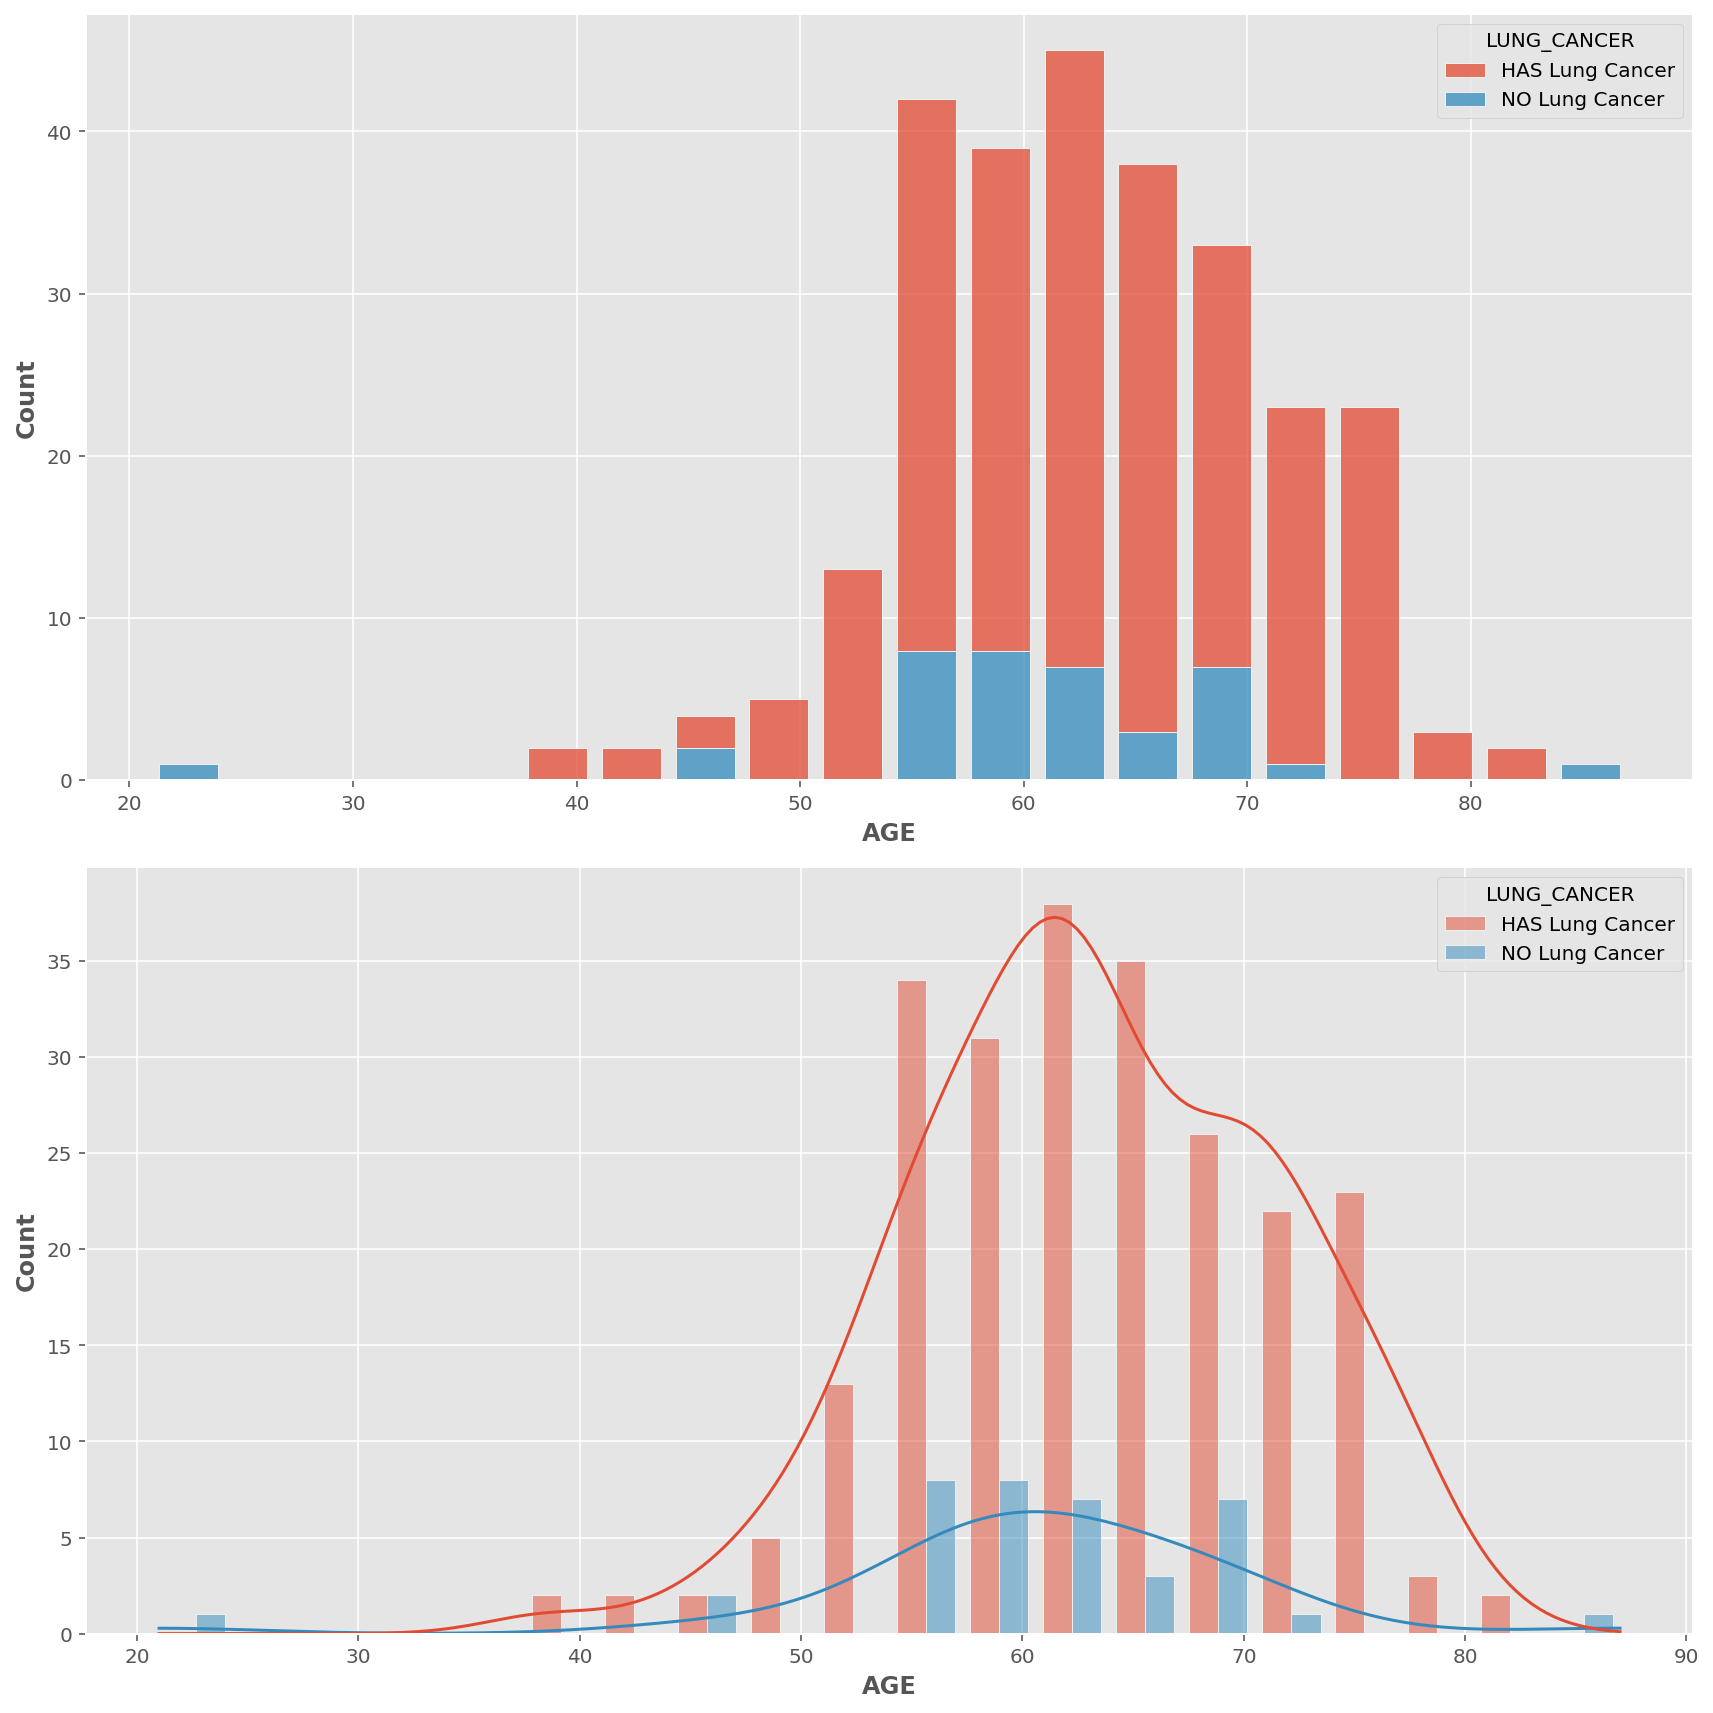

In [14]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 12))
sns.histplot(data=plot_df, x="AGE", hue="LUNG_CANCER", multiple="stack", shrink=.8, ax=ax1)
sns.histplot(data=plot_df, x="AGE",multiple="dodge", shrink=.8, hue="LUNG_CANCER",ax=ax2,  kde = True)

In [15]:
cat_var = df.nunique().loc[df.nunique()<=2].index
cat_var   # Categorical columns with 2 unique items

Index(['GENDER', 'SMOKING', 'YELLOW_FINGERS', 'ANXIETY', 'PEER_PRESSURE',
       'CHRONIC DISEASE', 'FATIGUE ', 'ALLERGY ', 'WHEEZING',
       'ALCOHOL CONSUMING', 'COUGHING', 'SHORTNESS OF BREATH',
       'SWALLOWING DIFFICULTY', 'CHEST PAIN', 'LUNG_CANCER'],
      dtype='object')

In [16]:
col=cat_var[0]
print(f'{round(plot_df[col].value_counts()[0]/len(df)*100)} % of instances are: {plot_df[col].value_counts().index[0]}')
print(f'{round(plot_df[col].value_counts()[1]/len(df)*100)} % of instances are: {plot_df[col].value_counts().index[1]}')

51 % of instances are: Male
49 % of instances are: Female


<AxesSubplot:xlabel='GENDER', ylabel='Percent'>

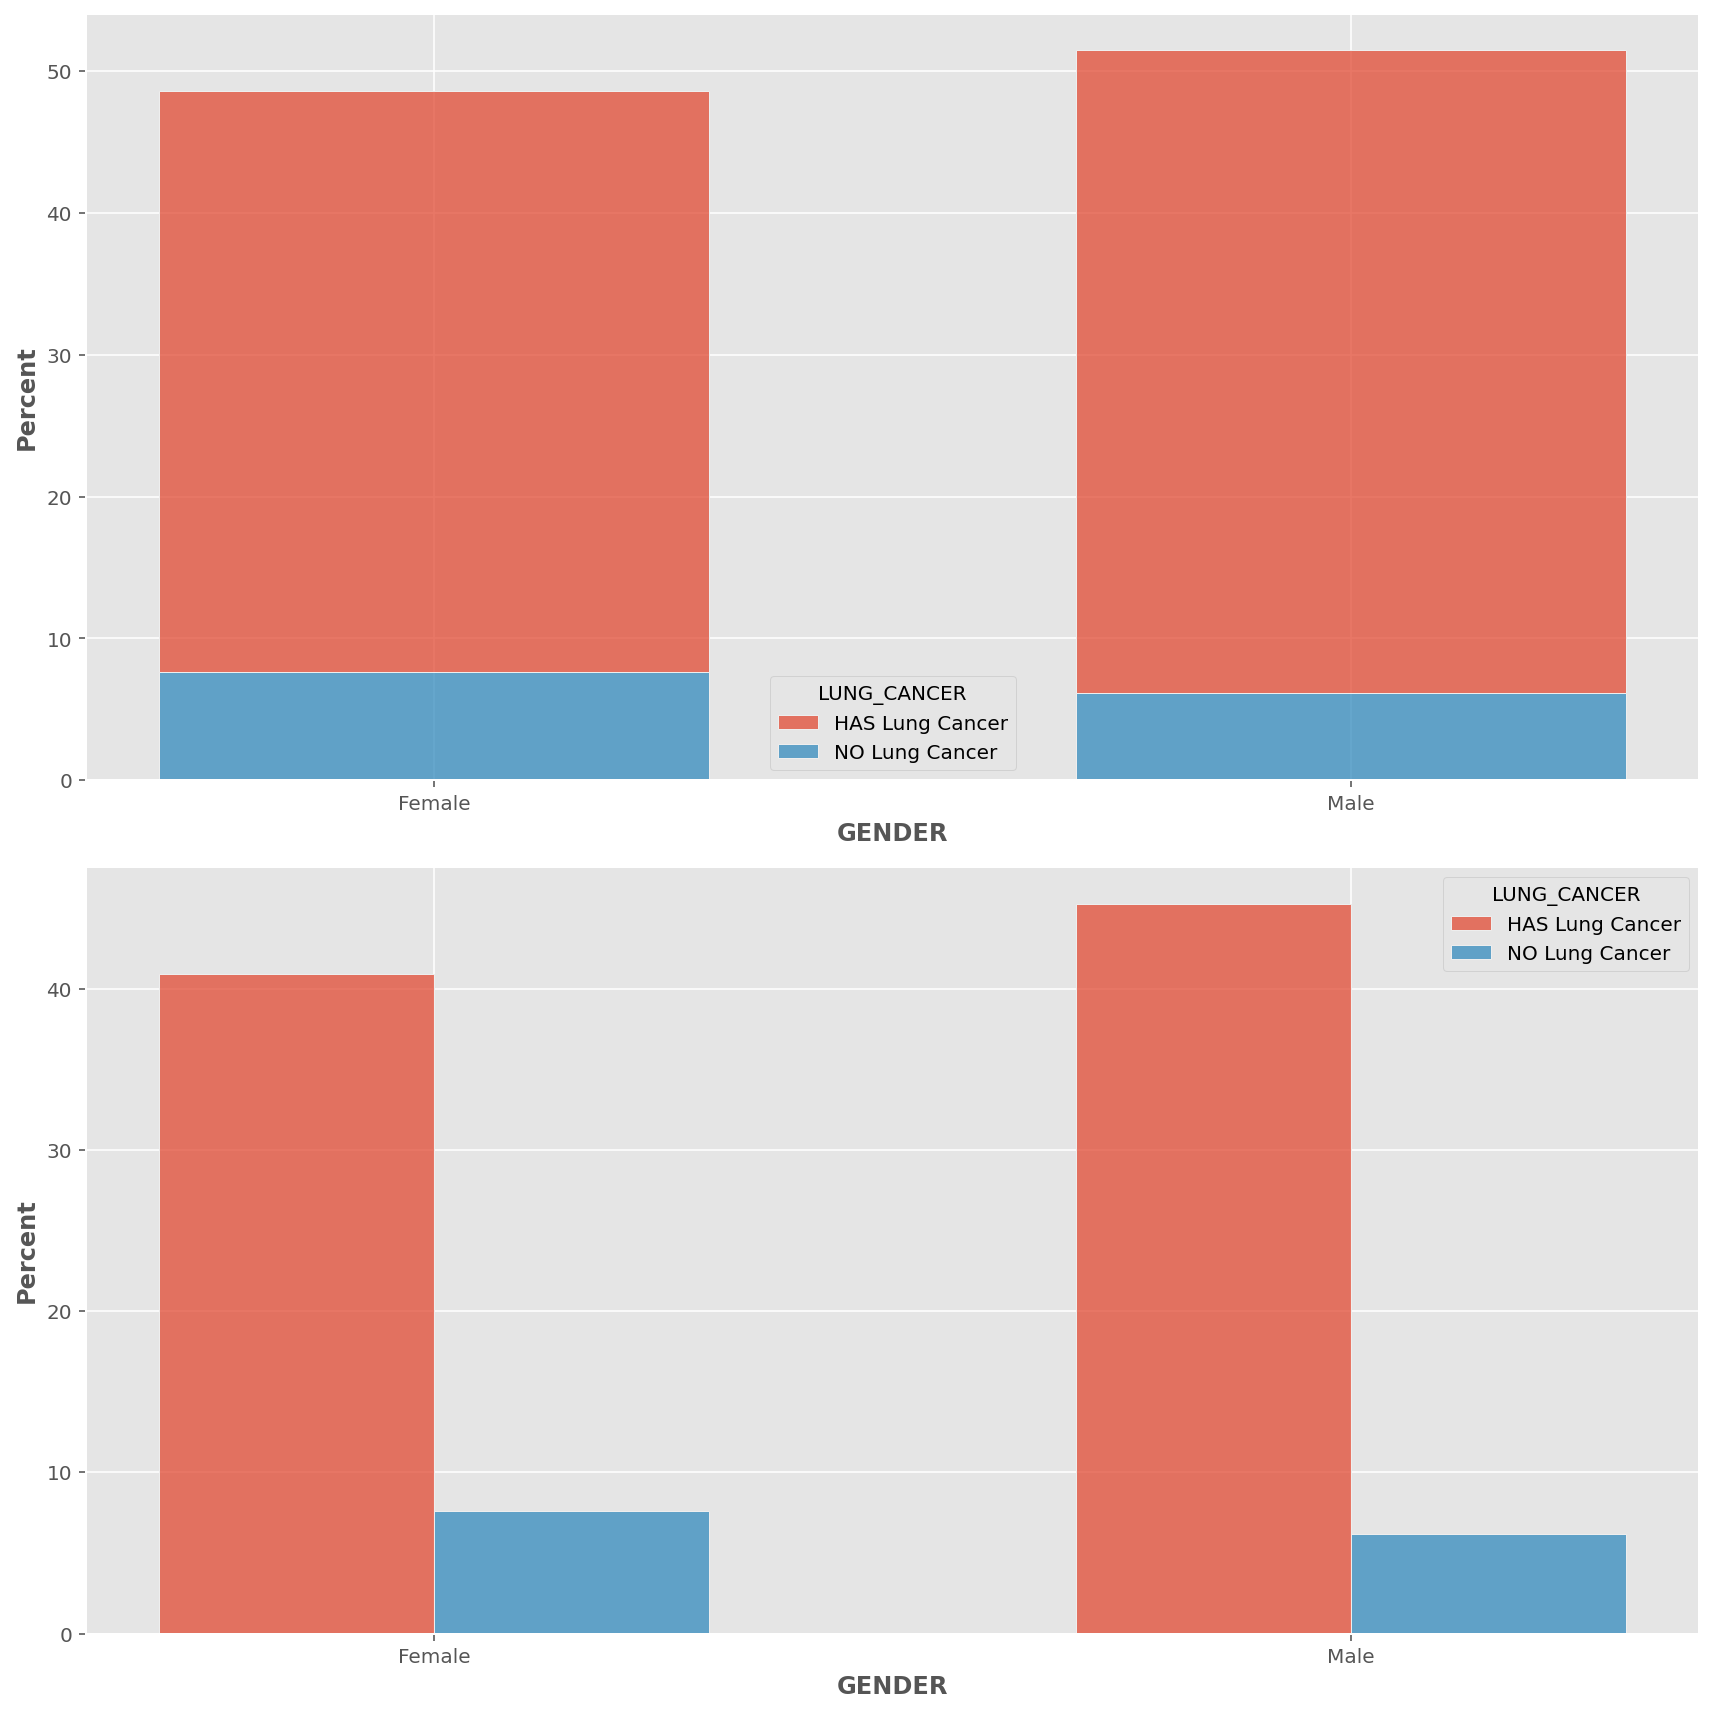

In [17]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 12))
sns.histplot(data=plot_df, x= col, hue= "LUNG_CANCER", multiple="stack",stat= 'percent', shrink=.6, ax=ax1,discrete=True)
sns.histplot(data=plot_df, x= col, hue= "LUNG_CANCER",multiple="dodge", shrink=.6, stat='percent' ,ax=ax2,discrete=True)

In [18]:
for col in cat_var[1:-1]:
    print(f'{round(df[col].value_counts()[2]/len(df)*100)} % answered YES to: {col}')
    print(f'{round(df[col].value_counts()[1]/len(df)*100)} % answered NO to: {col}')

54 % answered YES to: SMOKING
46 % answered NO to: SMOKING
58 % answered YES to: YELLOW_FINGERS
42 % answered NO to: YELLOW_FINGERS
50 % answered YES to: ANXIETY
50 % answered NO to: ANXIETY
51 % answered YES to: PEER_PRESSURE
49 % answered NO to: PEER_PRESSURE
52 % answered YES to: CHRONIC DISEASE
48 % answered NO to: CHRONIC DISEASE
66 % answered YES to: FATIGUE 
34 % answered NO to: FATIGUE 
55 % answered YES to: ALLERGY 
45 % answered NO to: ALLERGY 
55 % answered YES to: WHEEZING
45 % answered NO to: WHEEZING
55 % answered YES to: ALCOHOL CONSUMING
45 % answered NO to: ALCOHOL CONSUMING
58 % answered YES to: COUGHING
42 % answered NO to: COUGHING
63 % answered YES to: SHORTNESS OF BREATH
37 % answered NO to: SHORTNESS OF BREATH
47 % answered YES to: SWALLOWING DIFFICULTY
53 % answered NO to: SWALLOWING DIFFICULTY
56 % answered YES to: CHEST PAIN
44 % answered NO to: CHEST PAIN


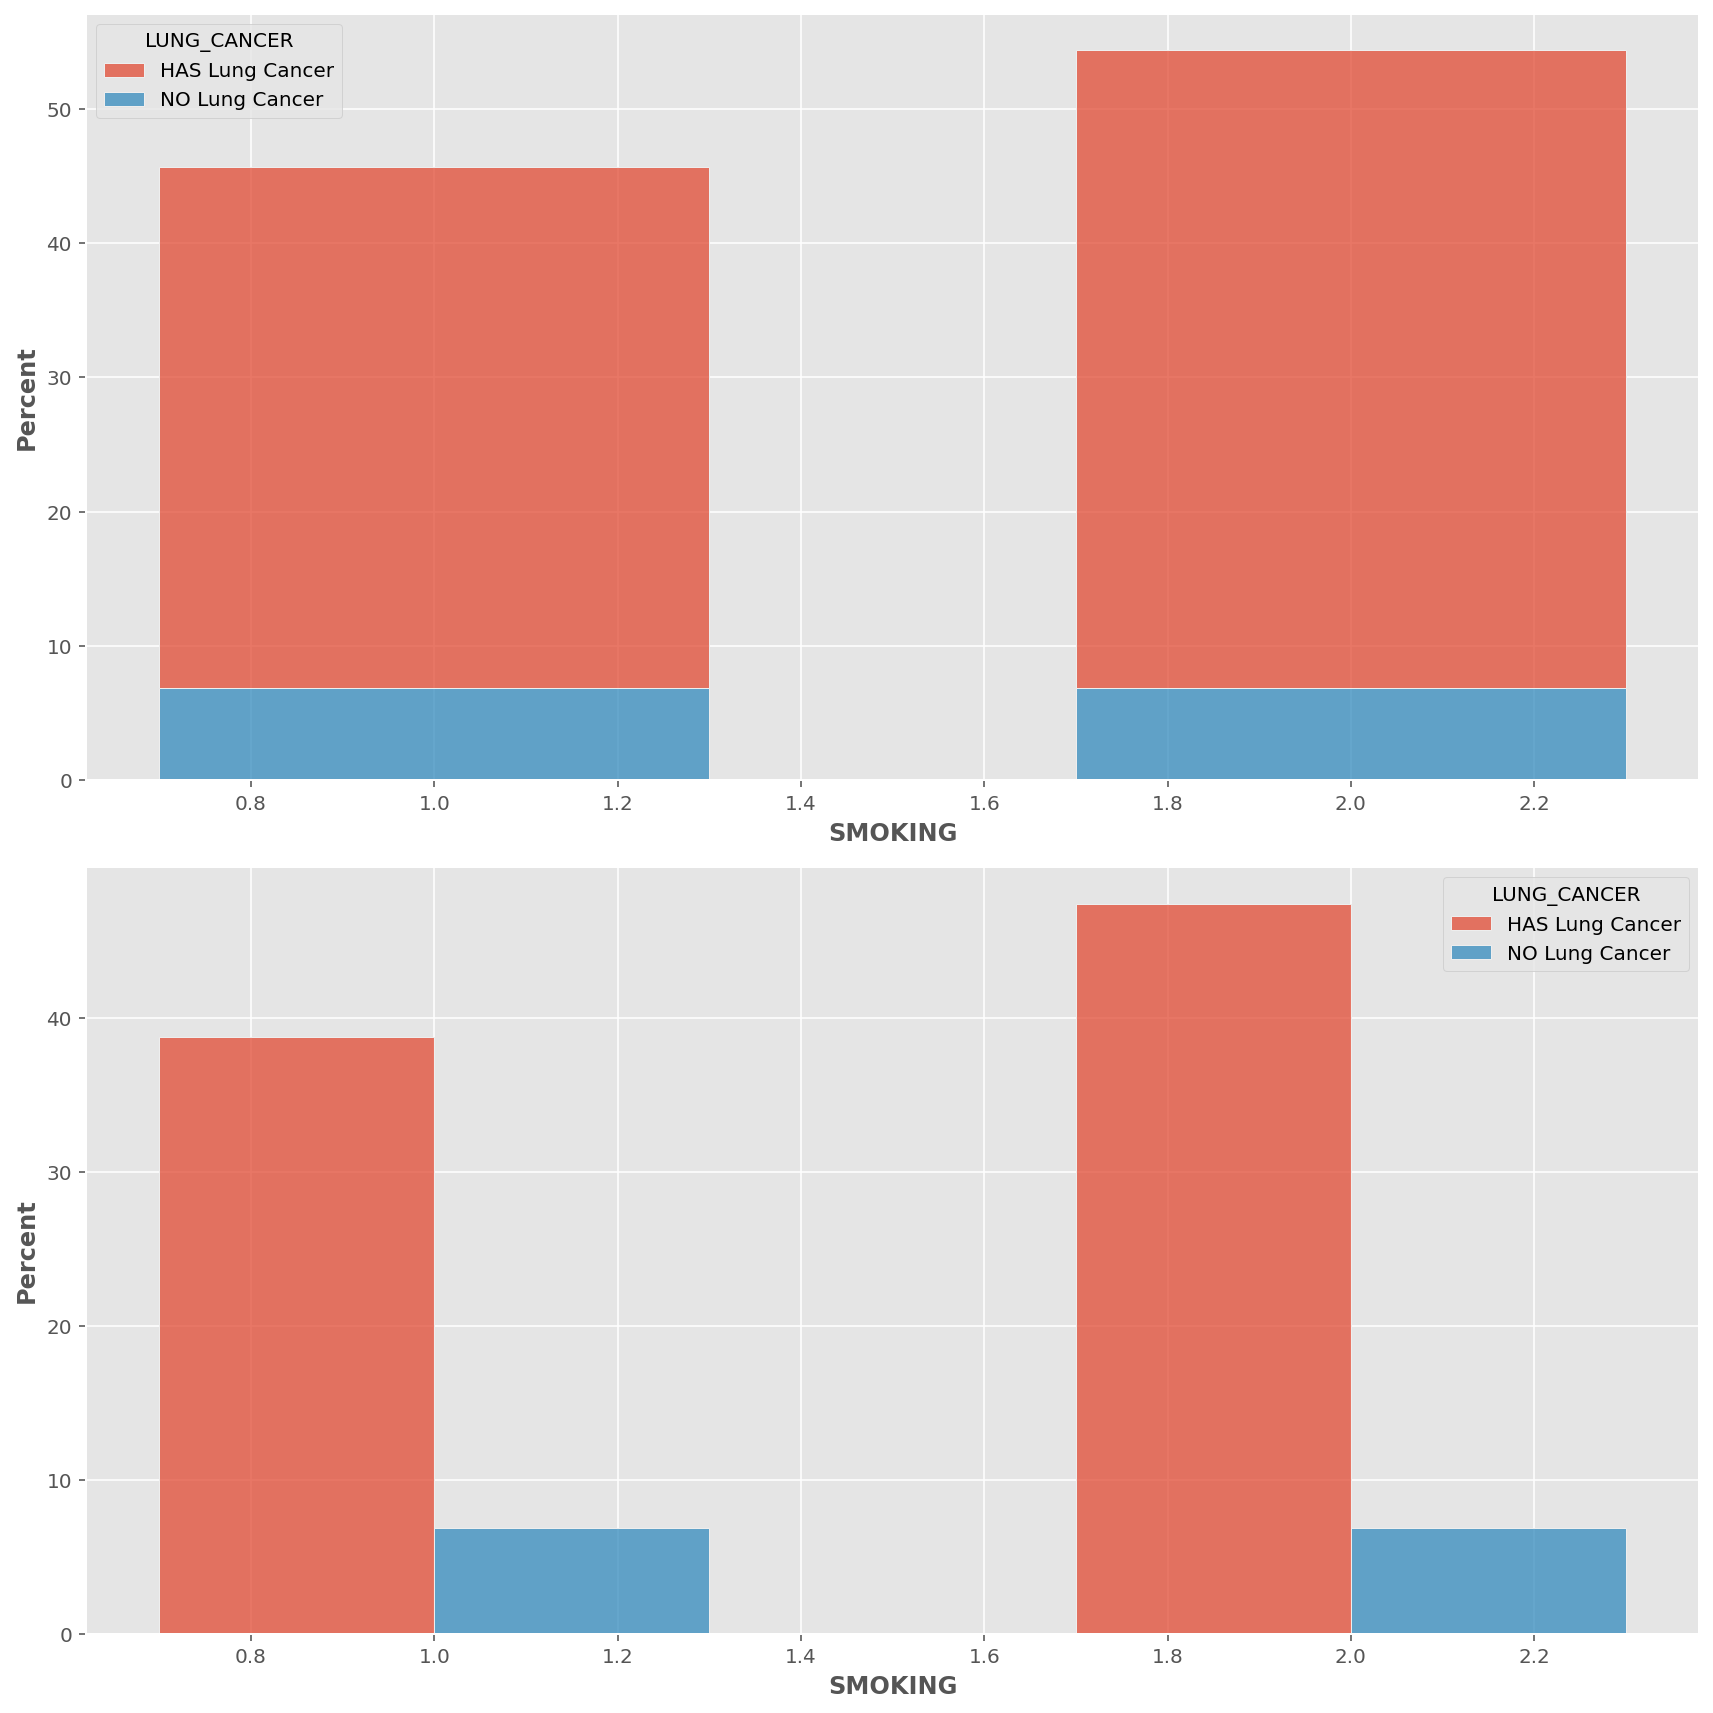

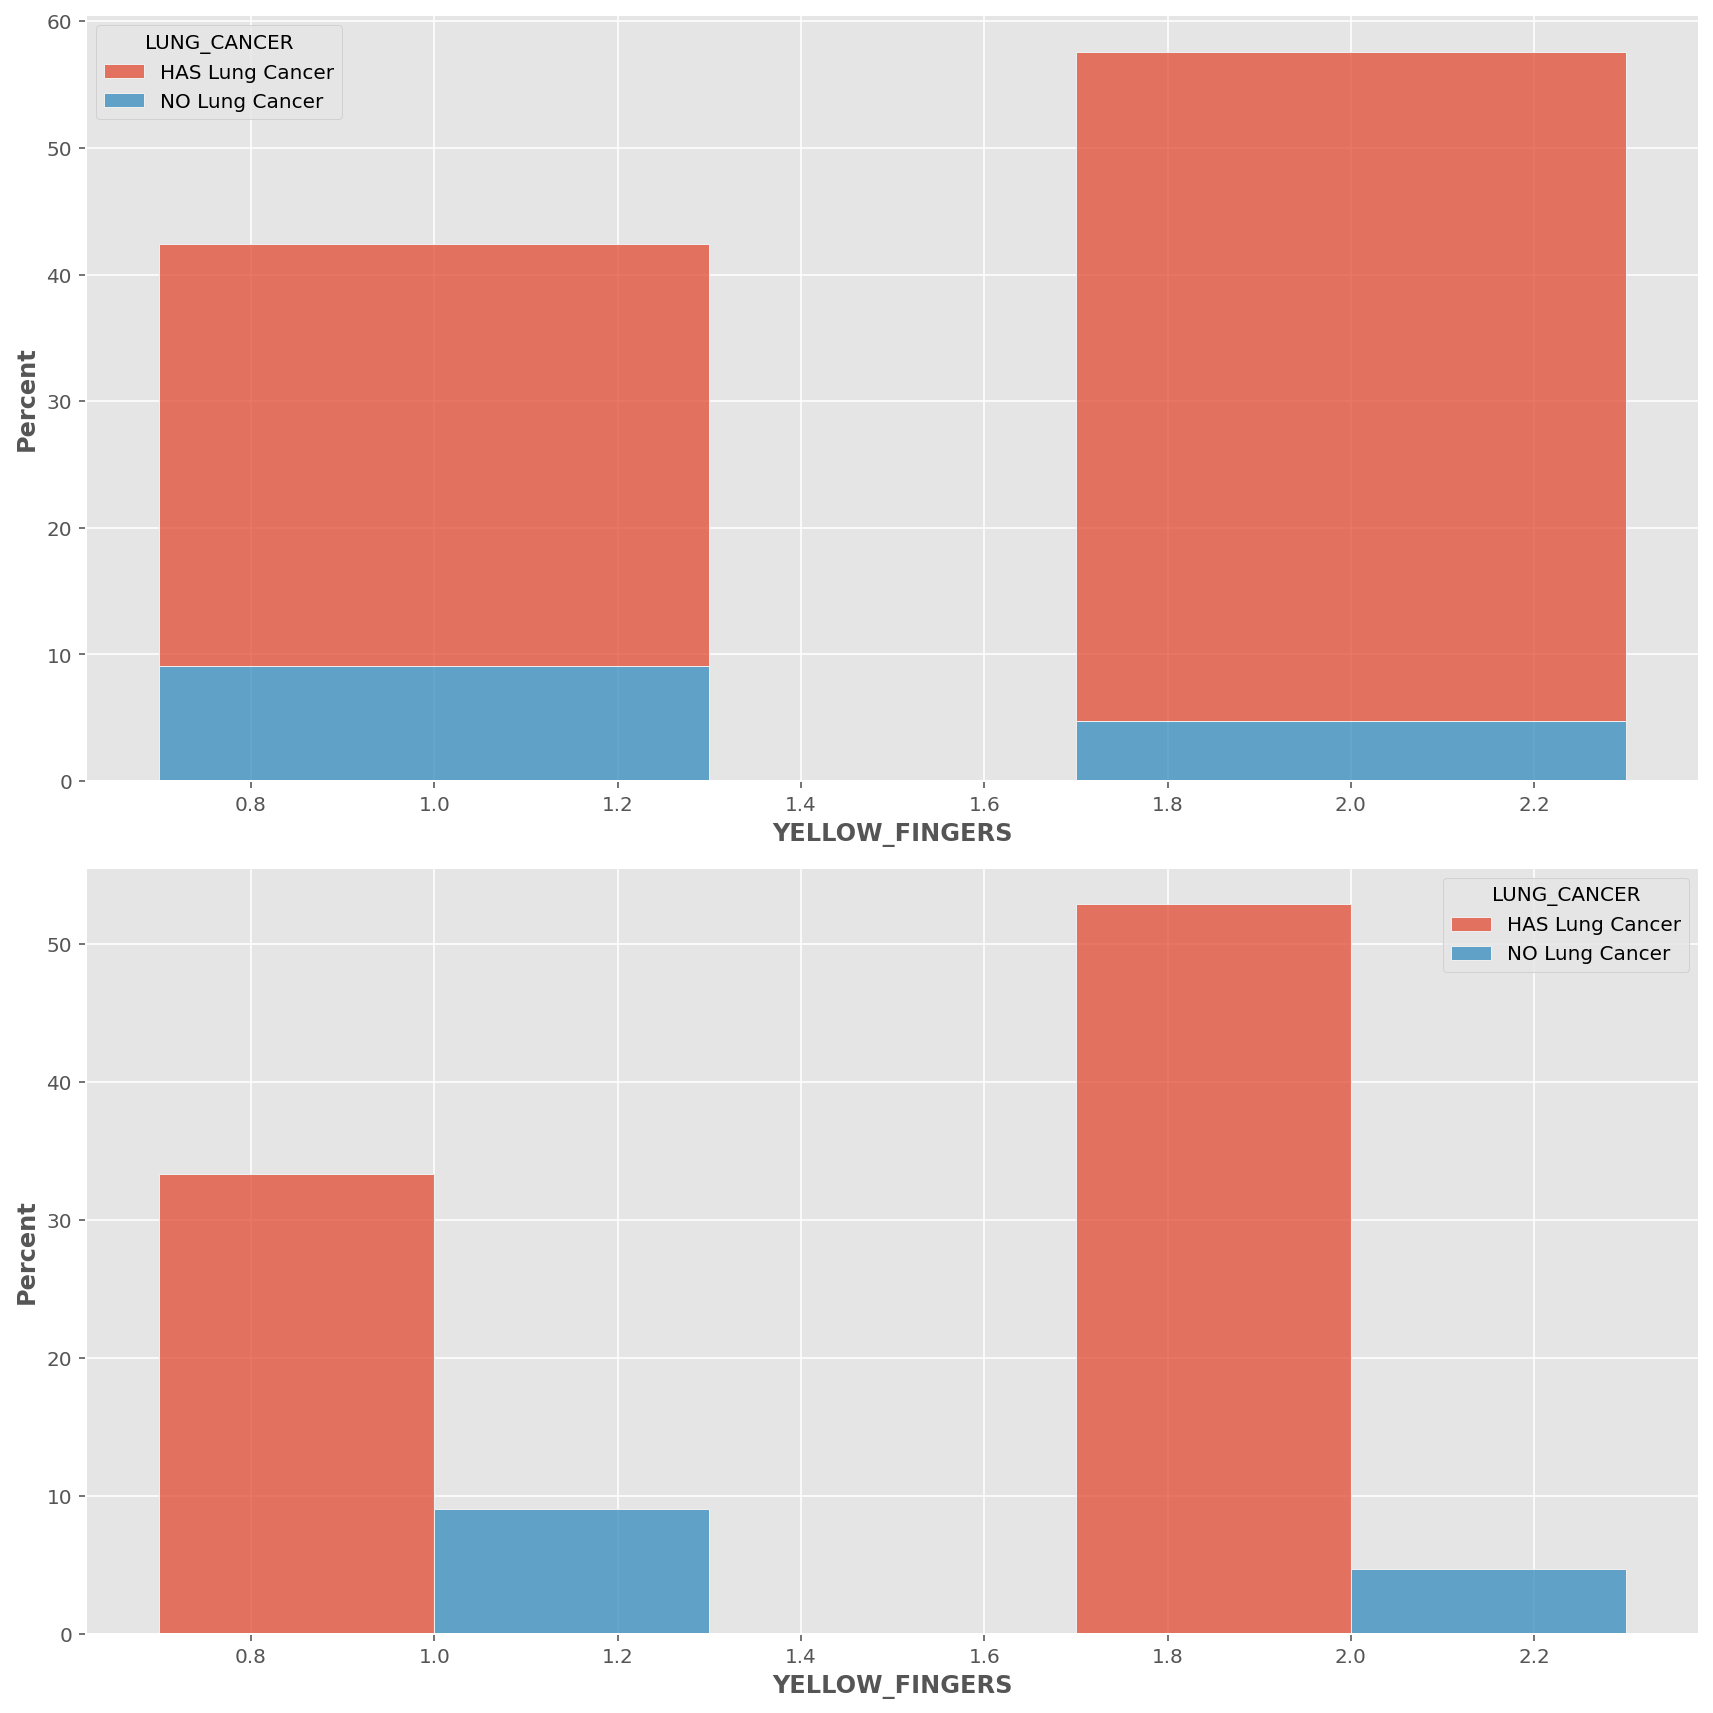

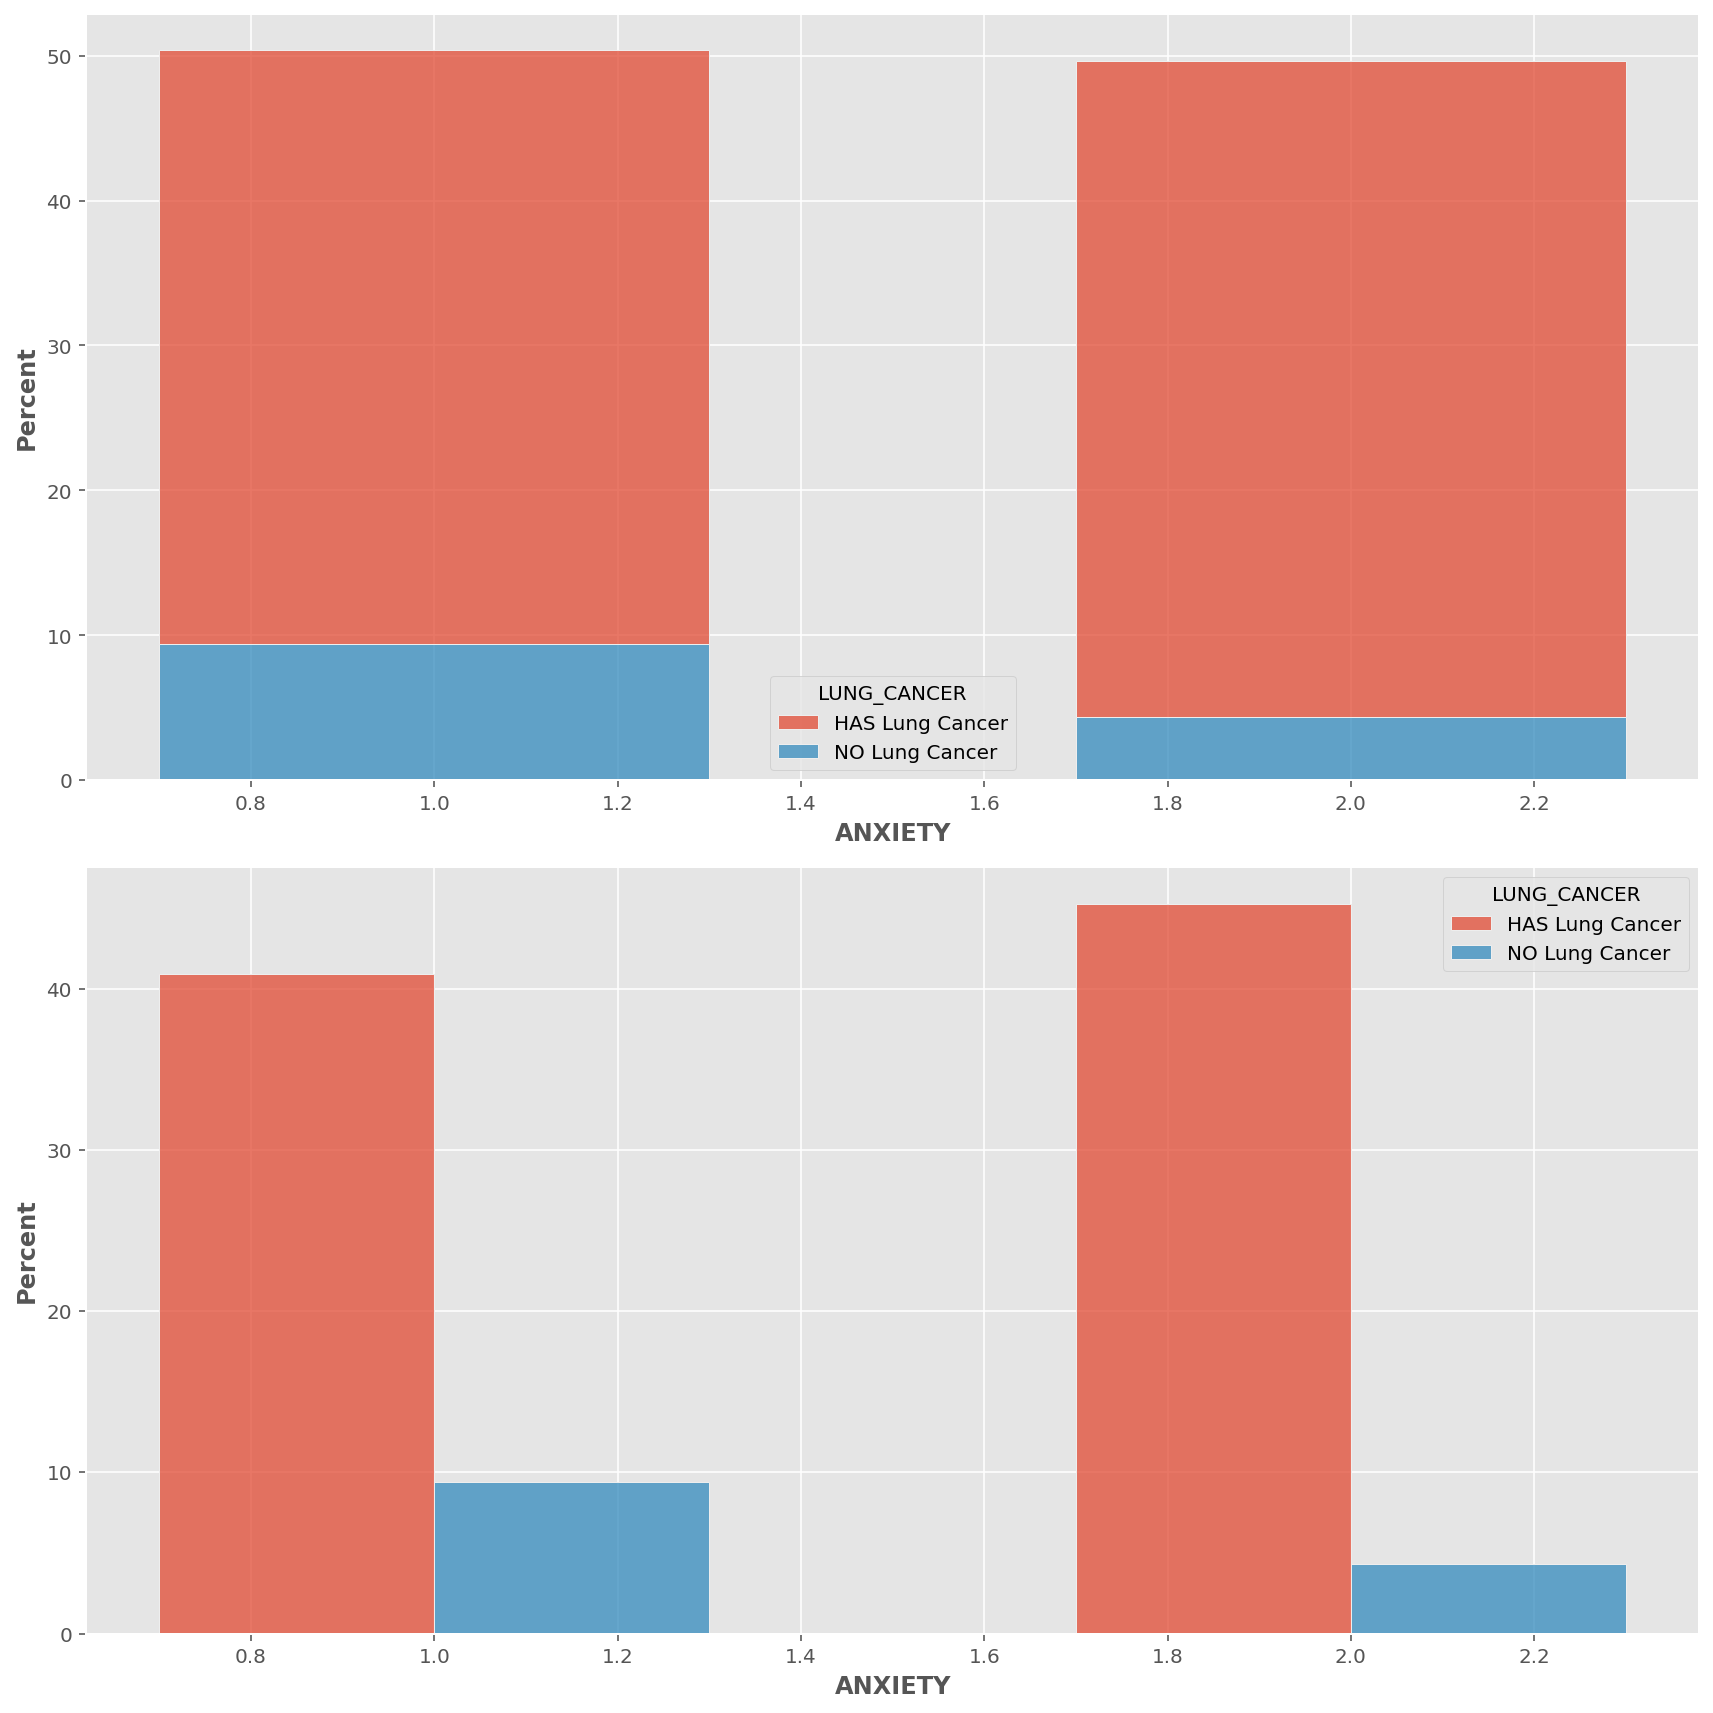

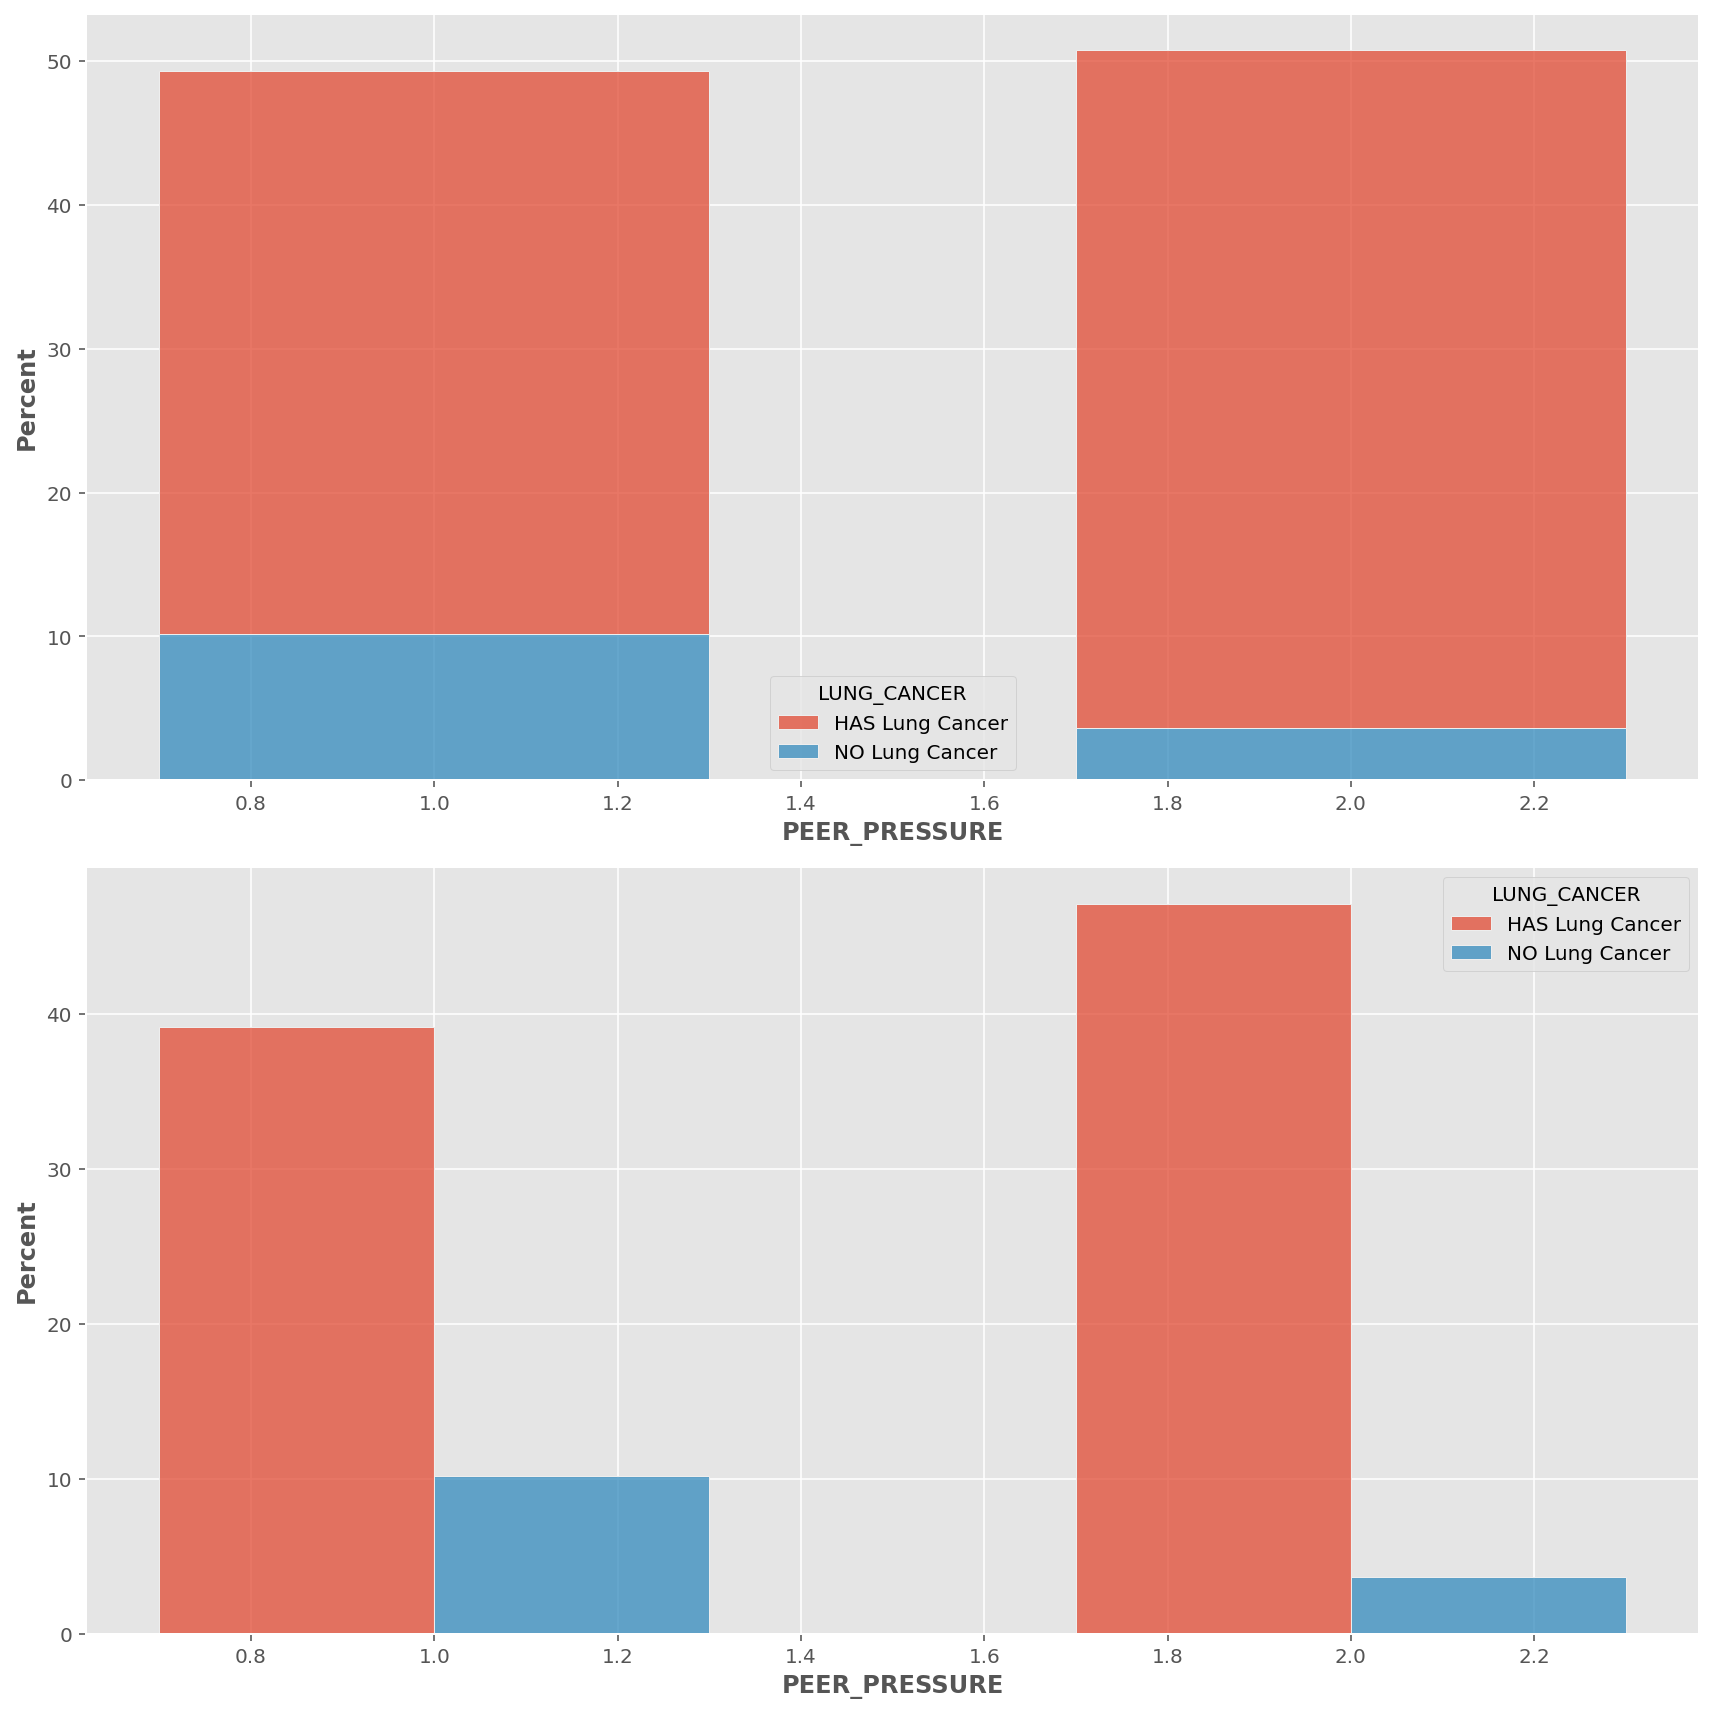

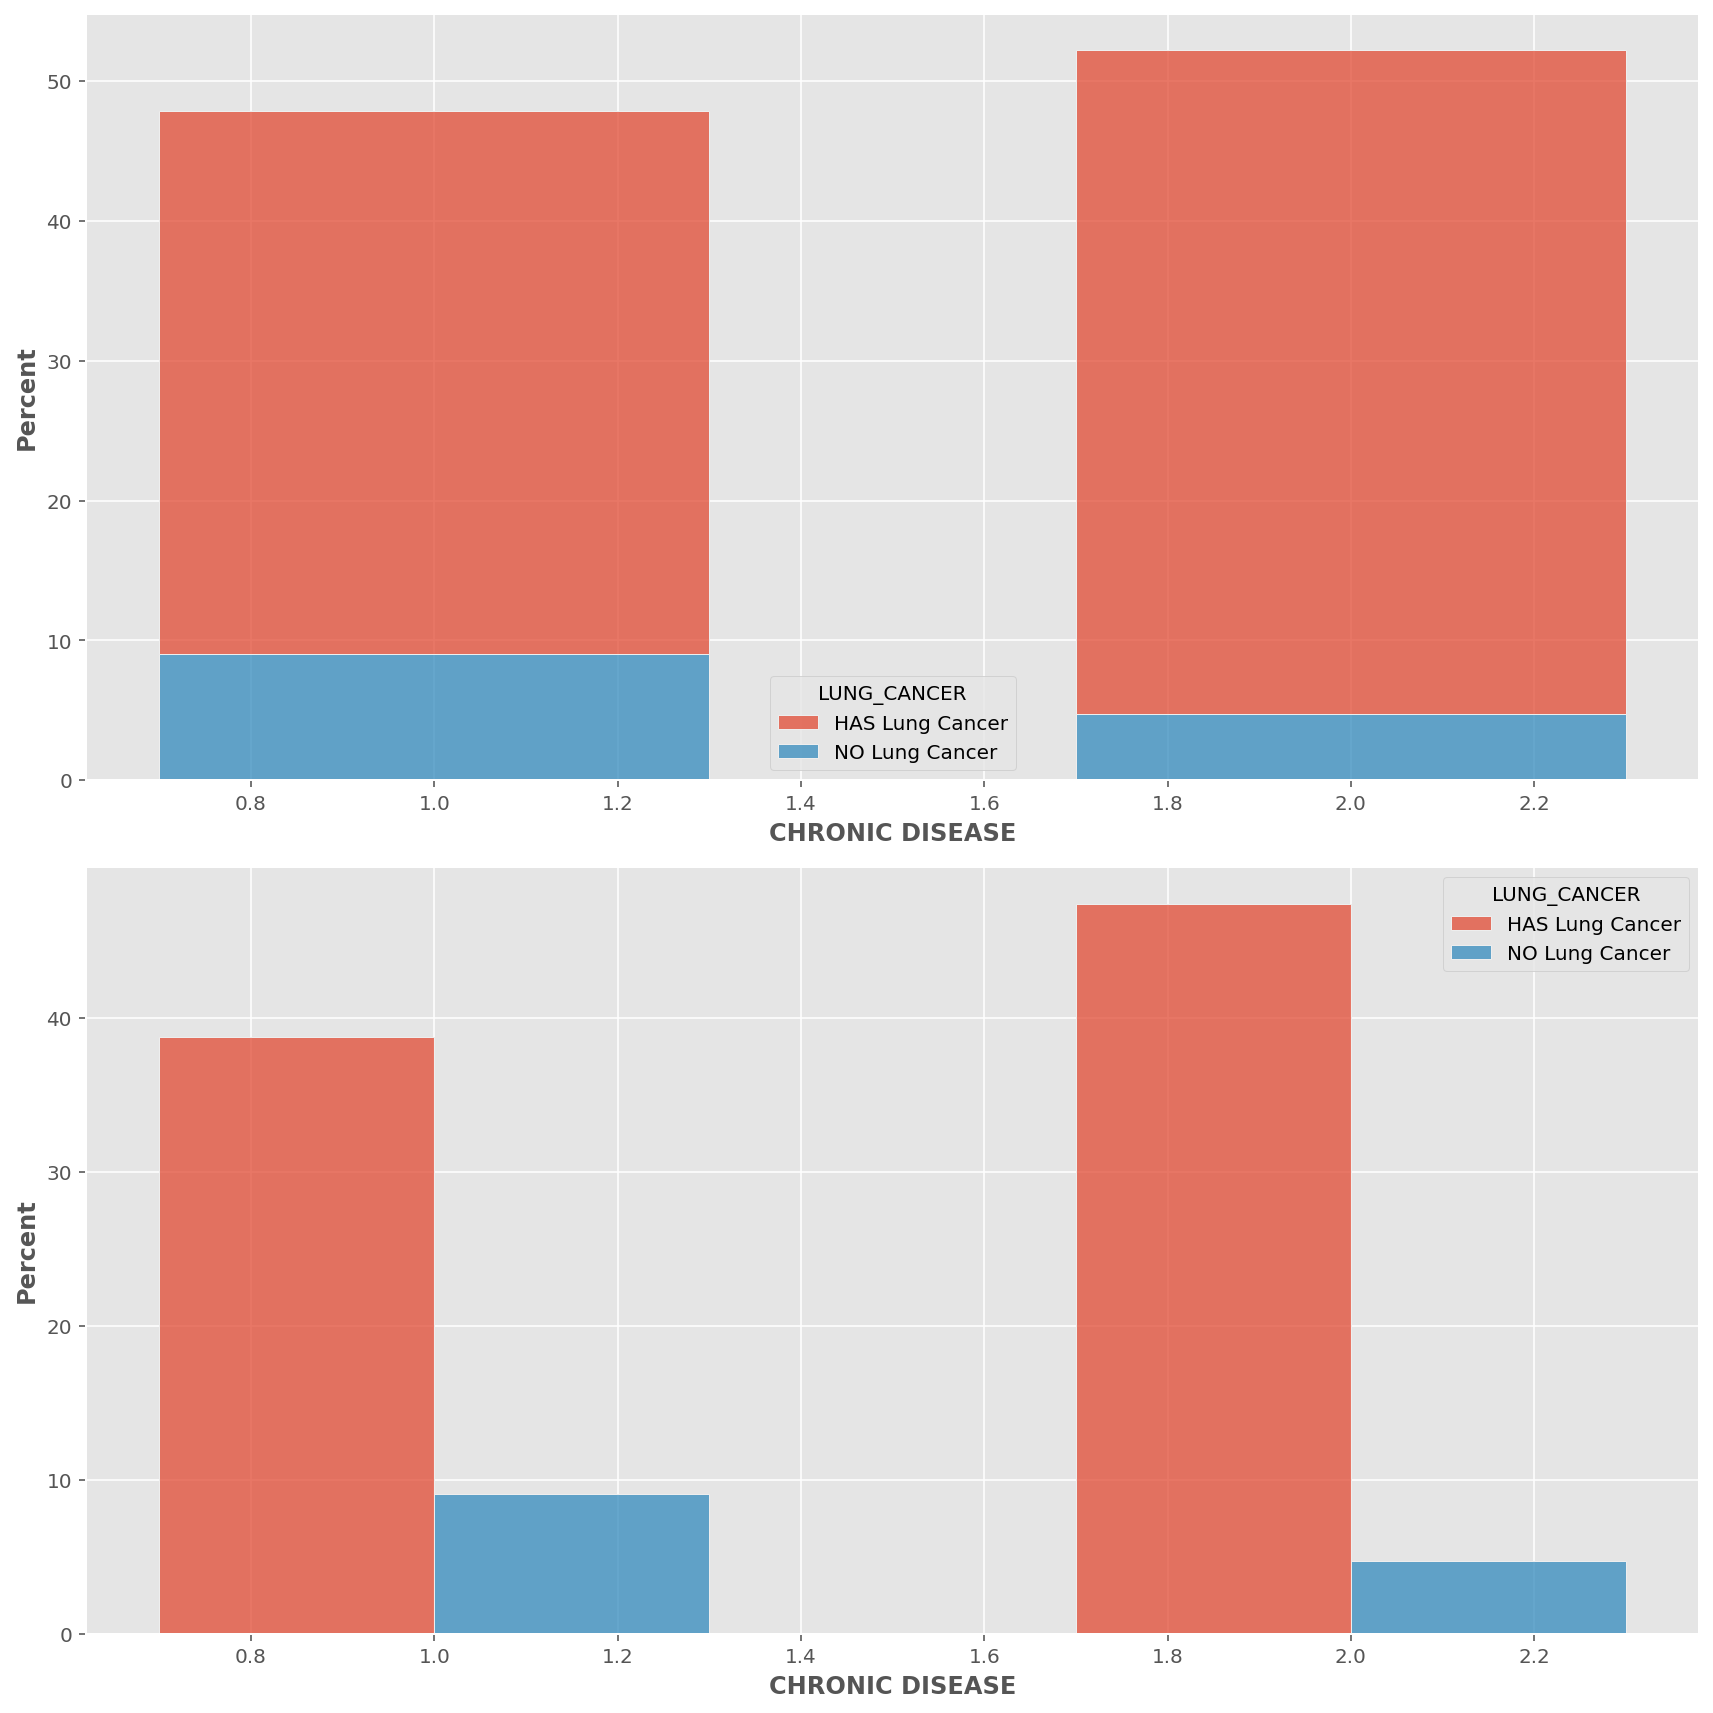

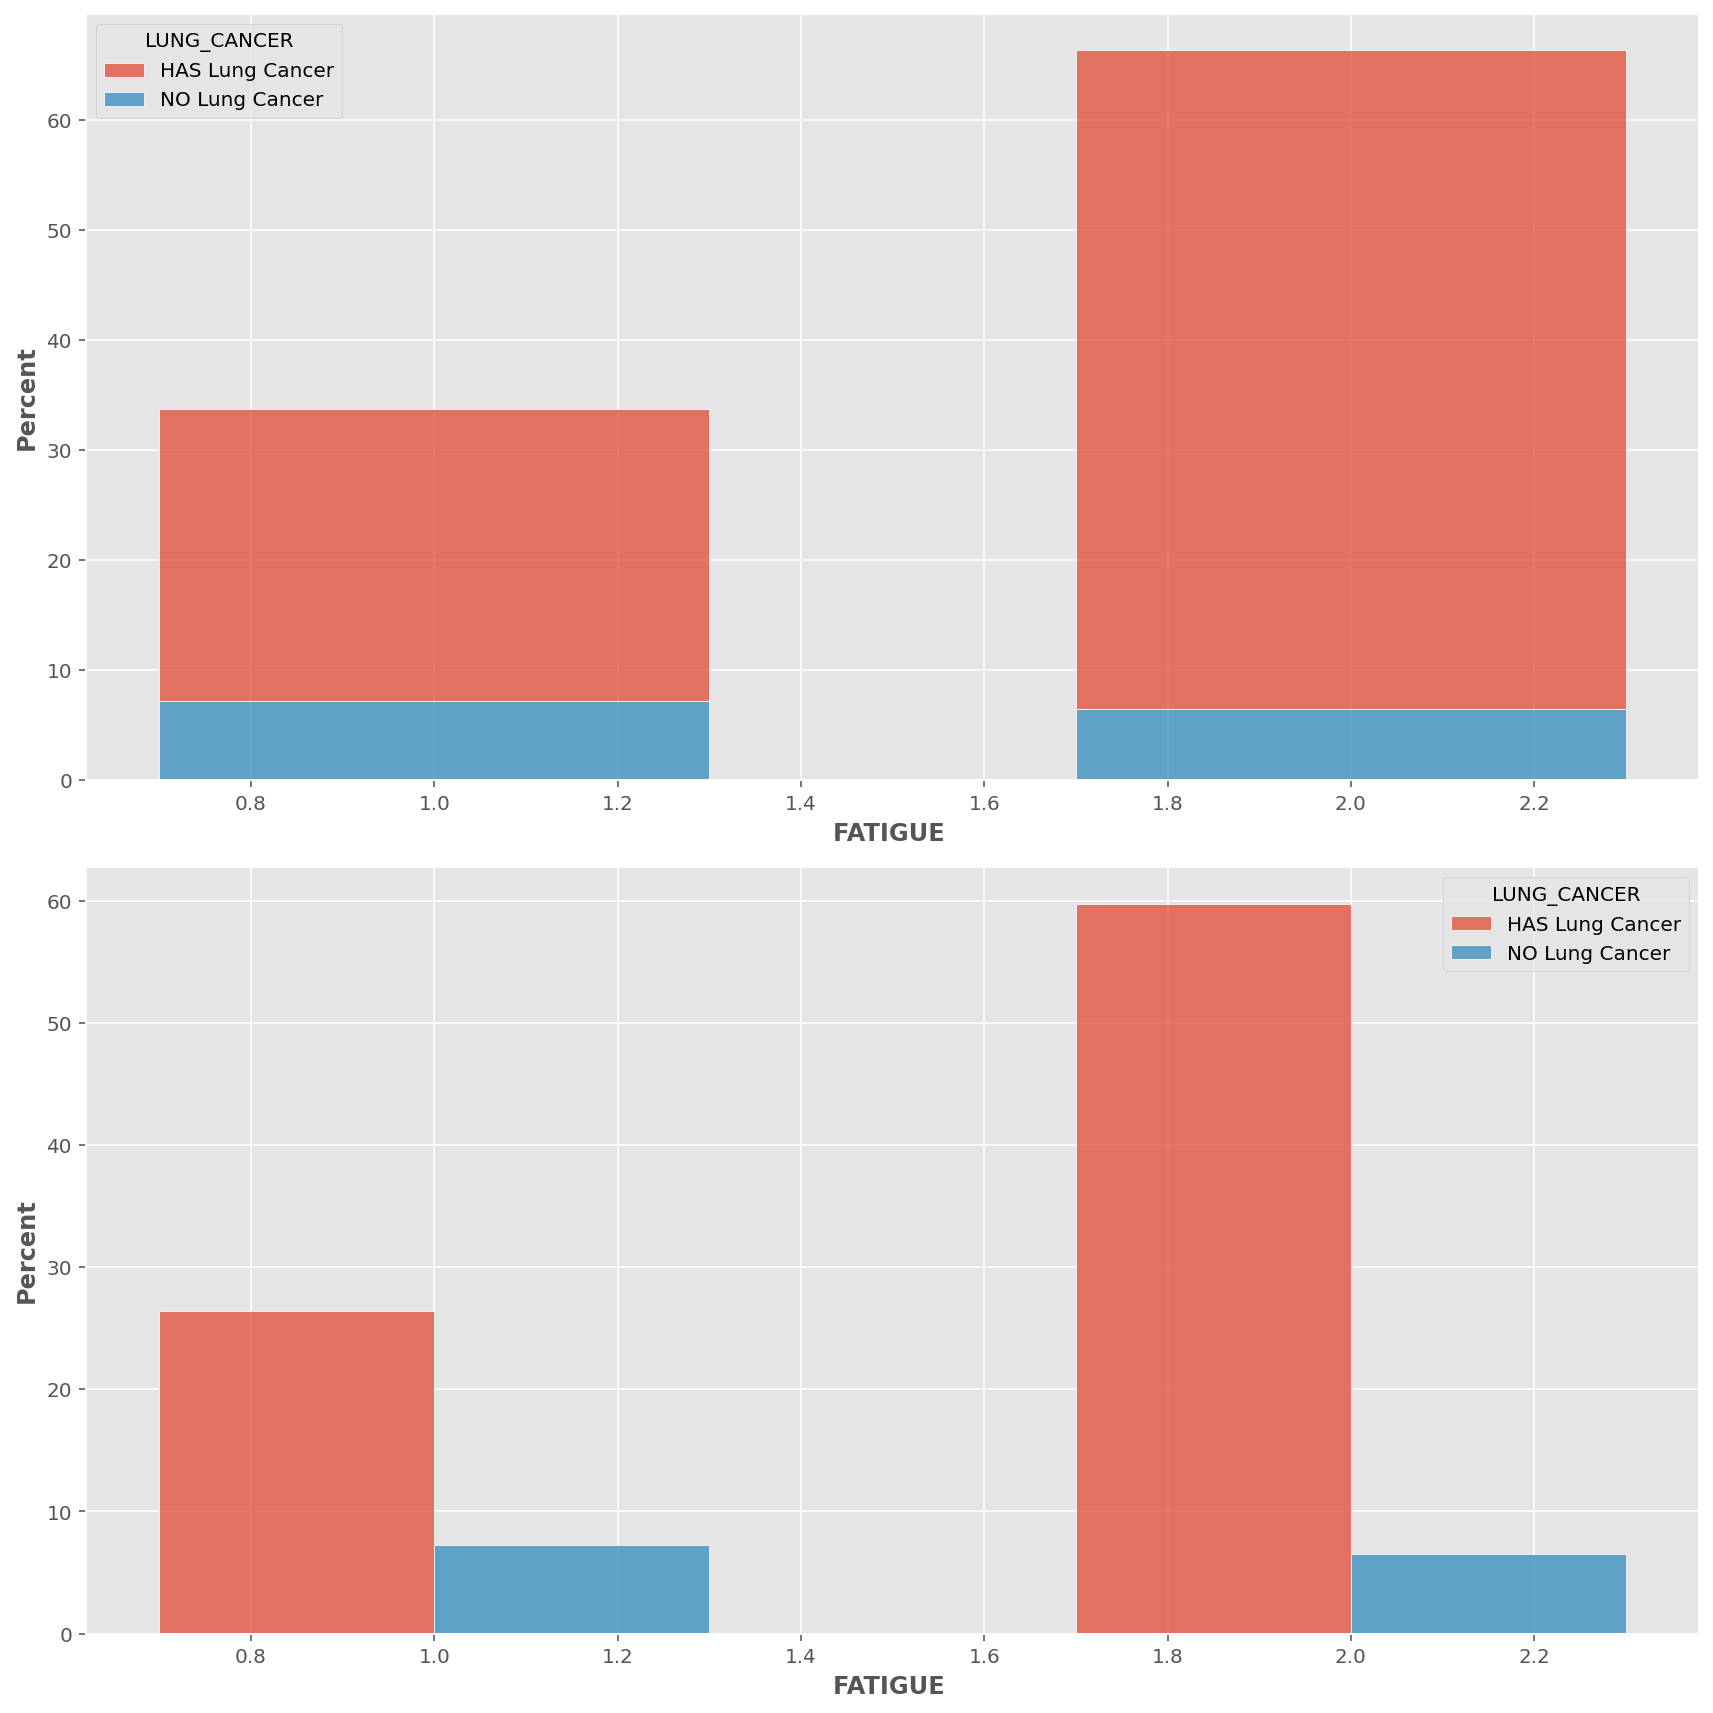

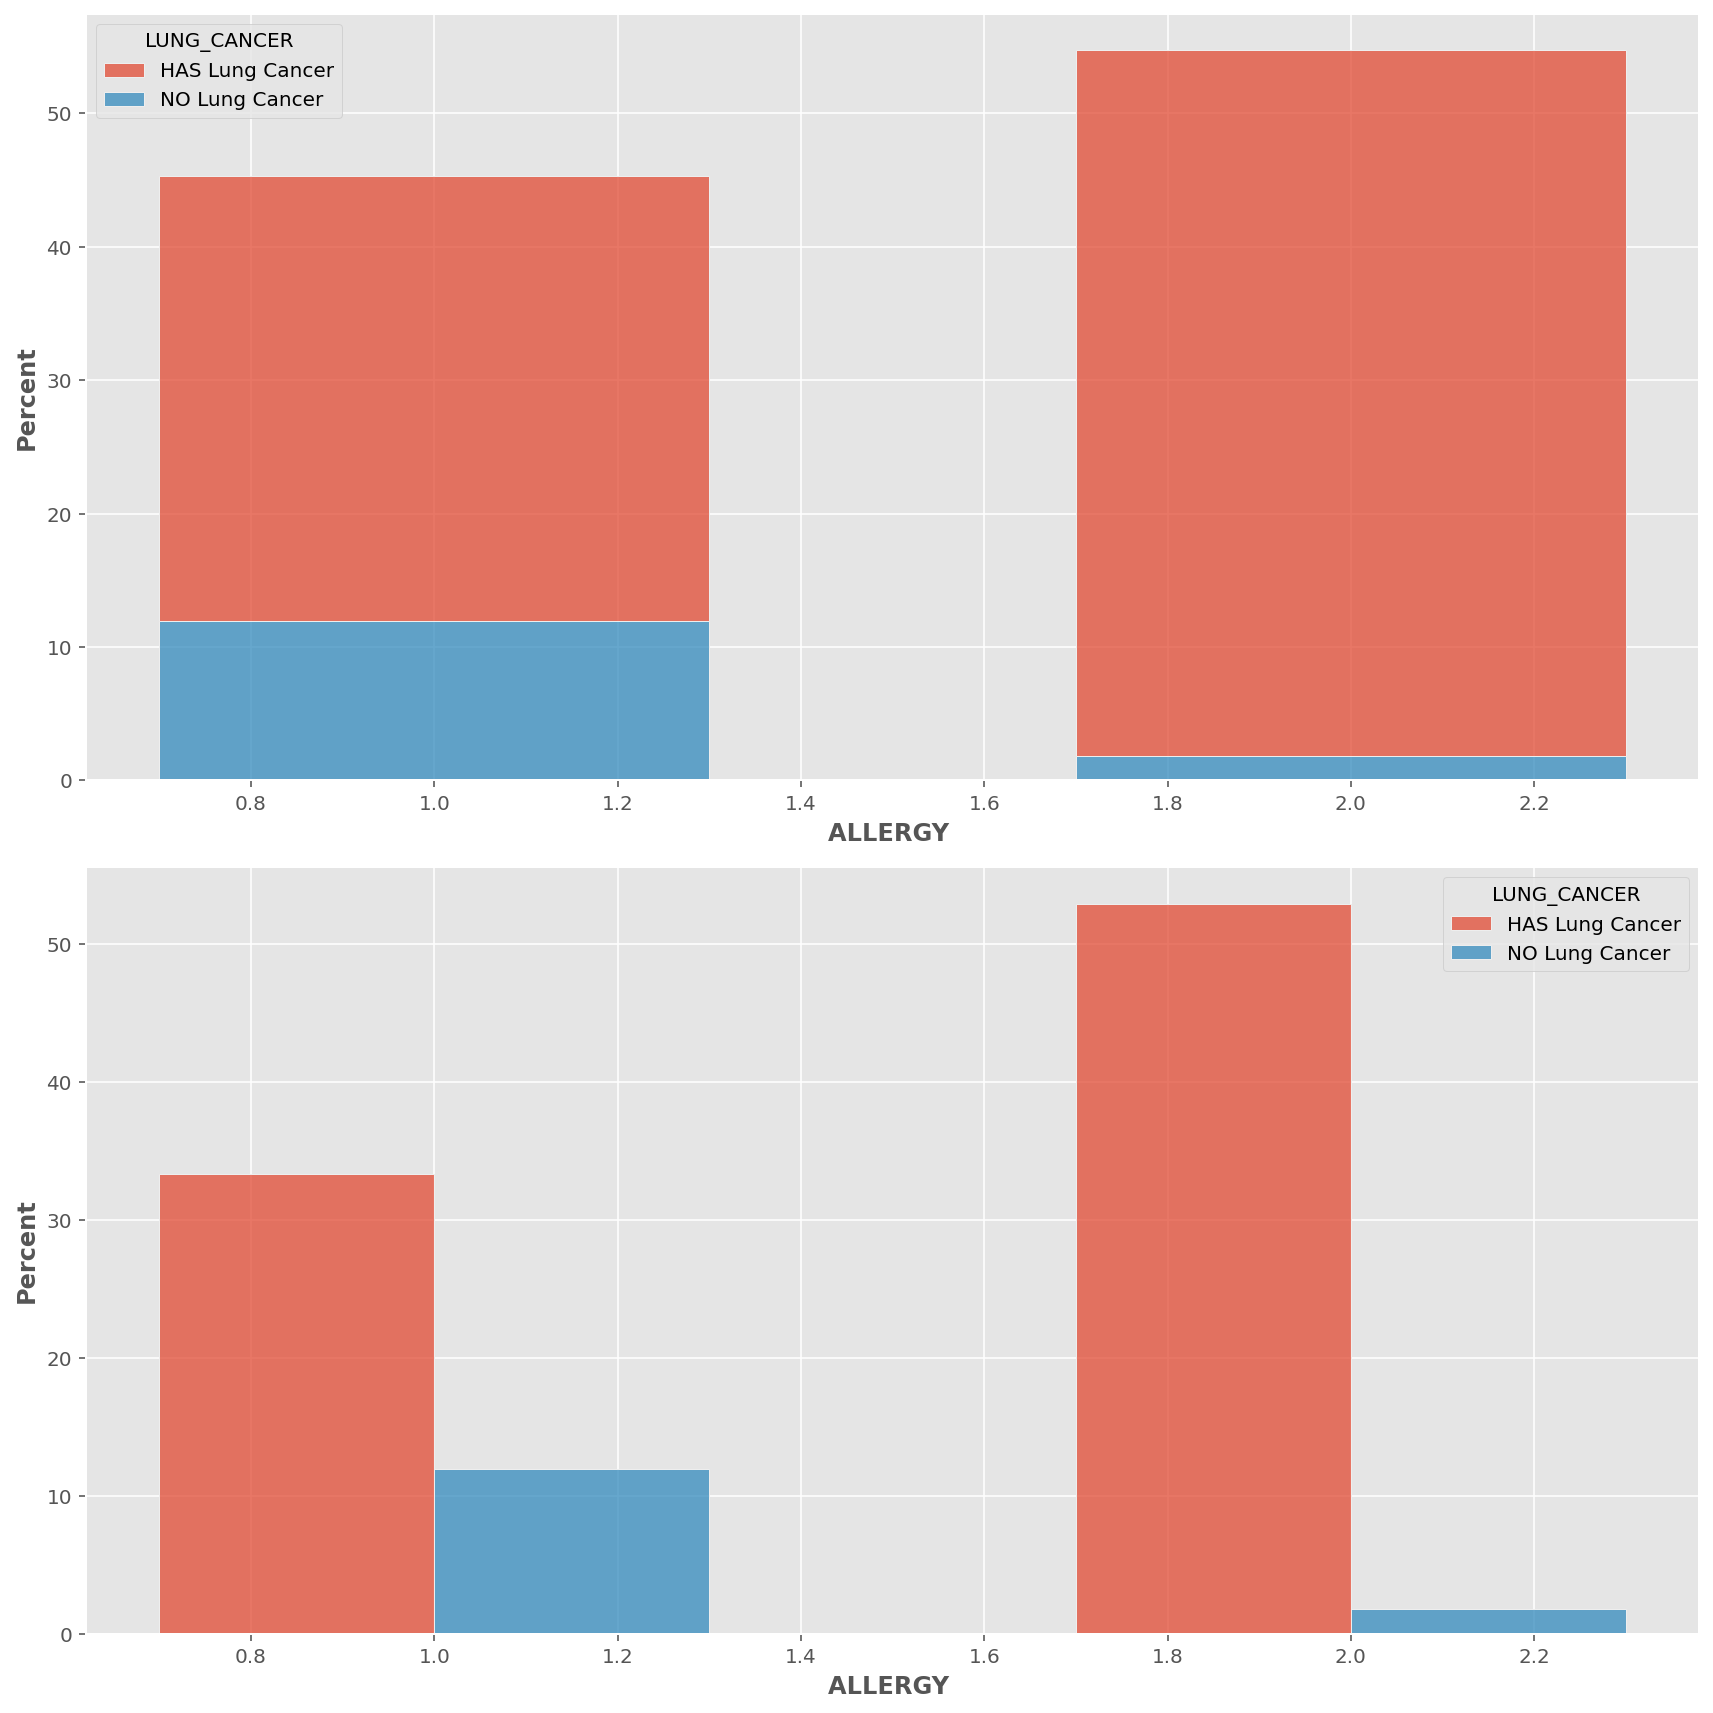

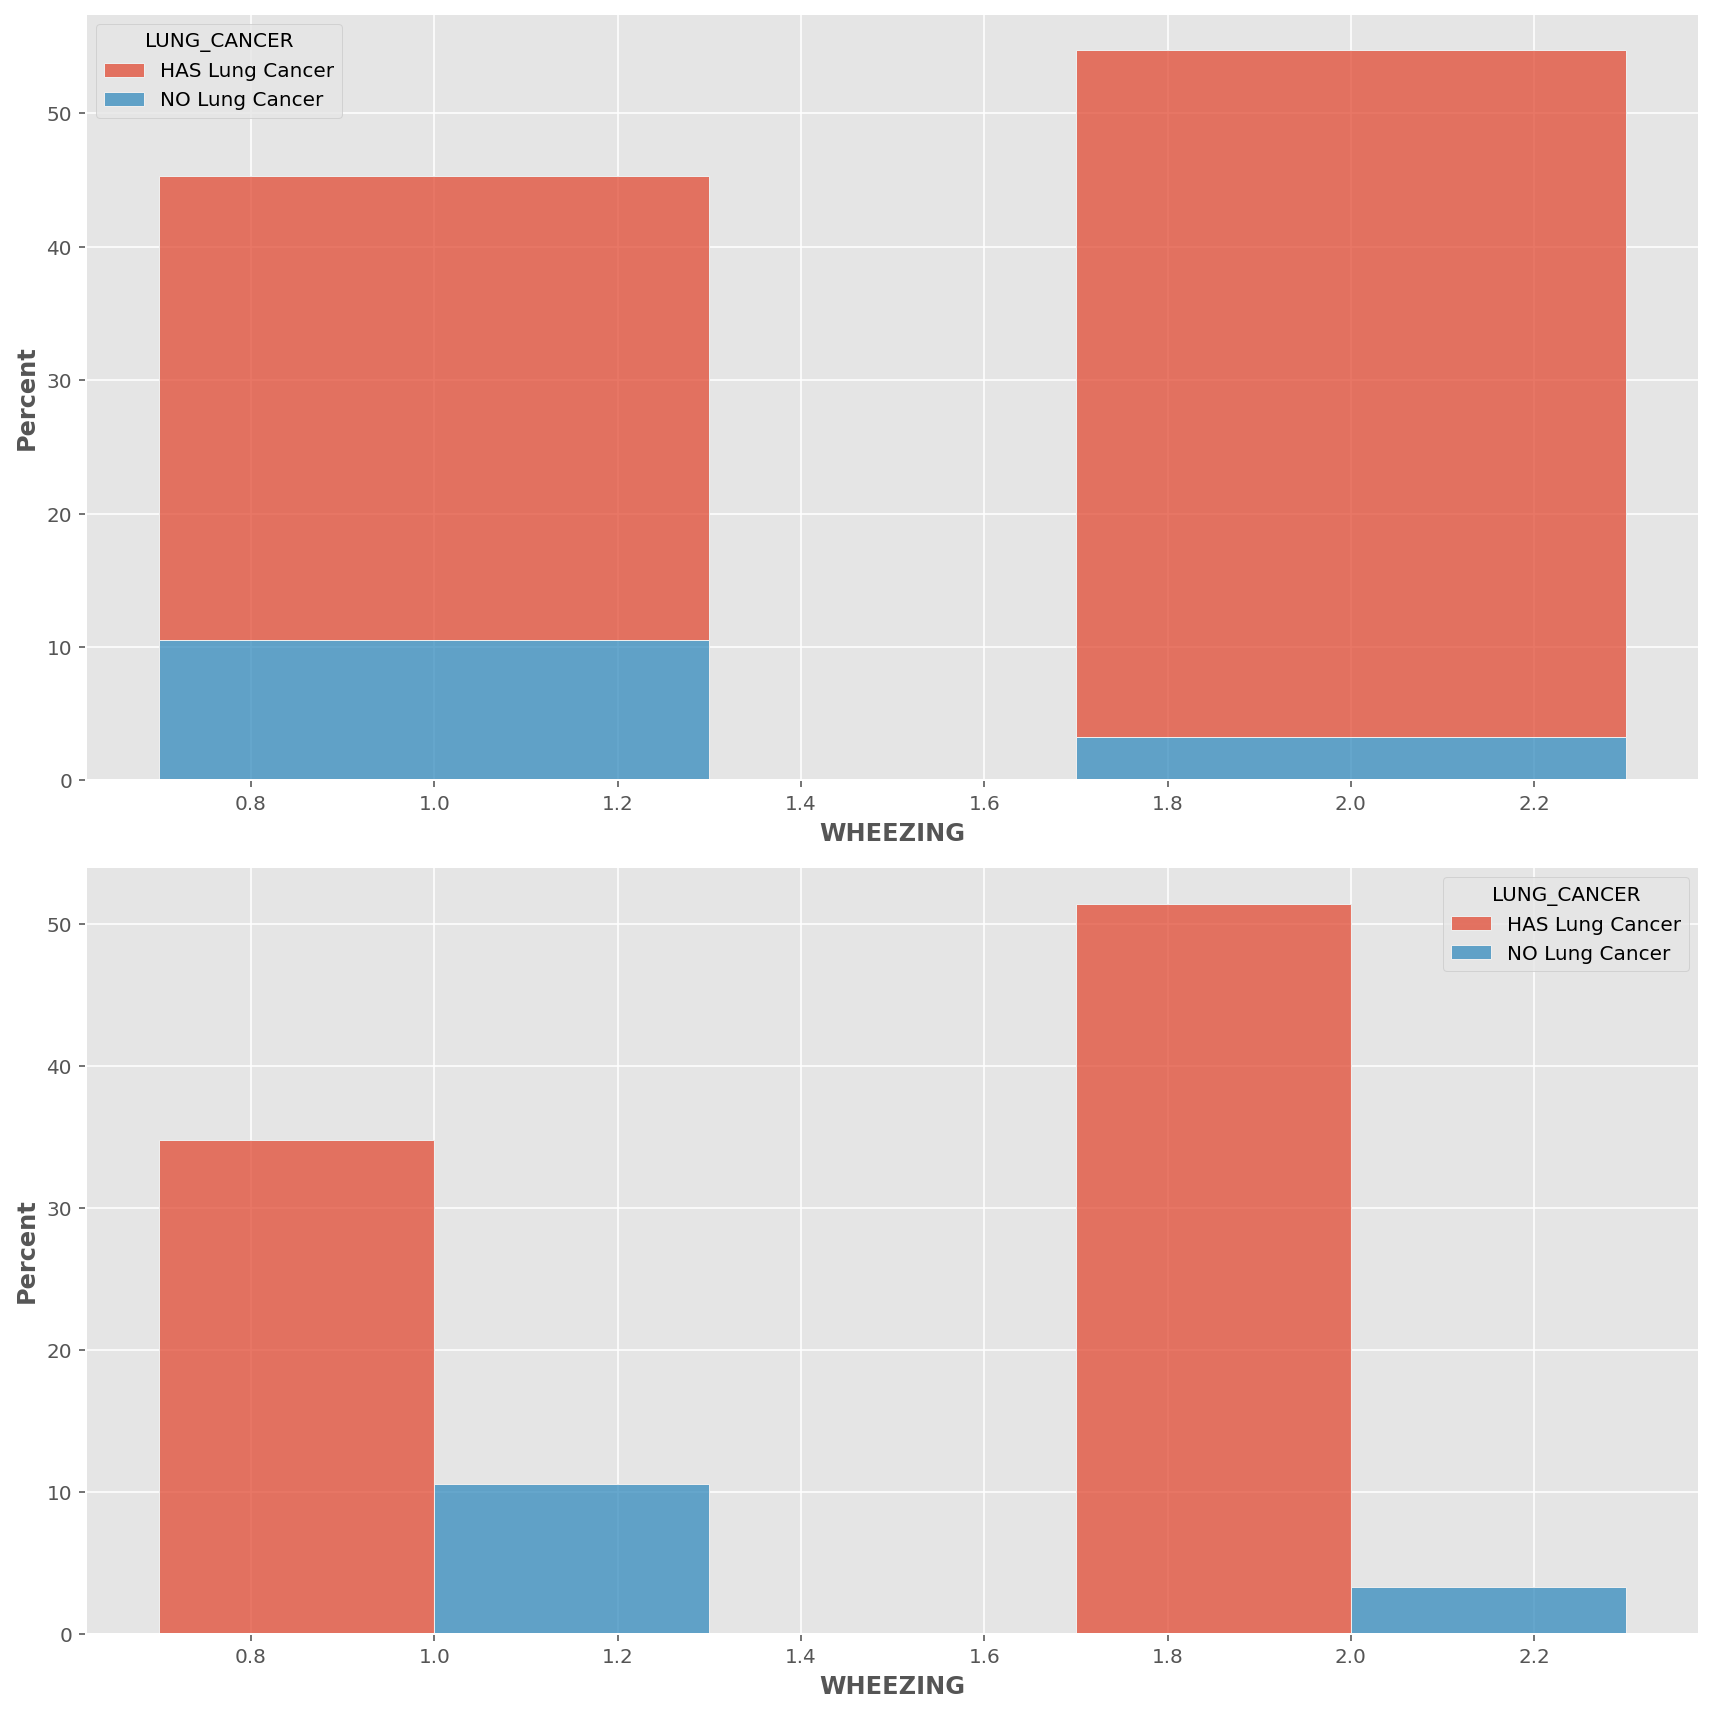

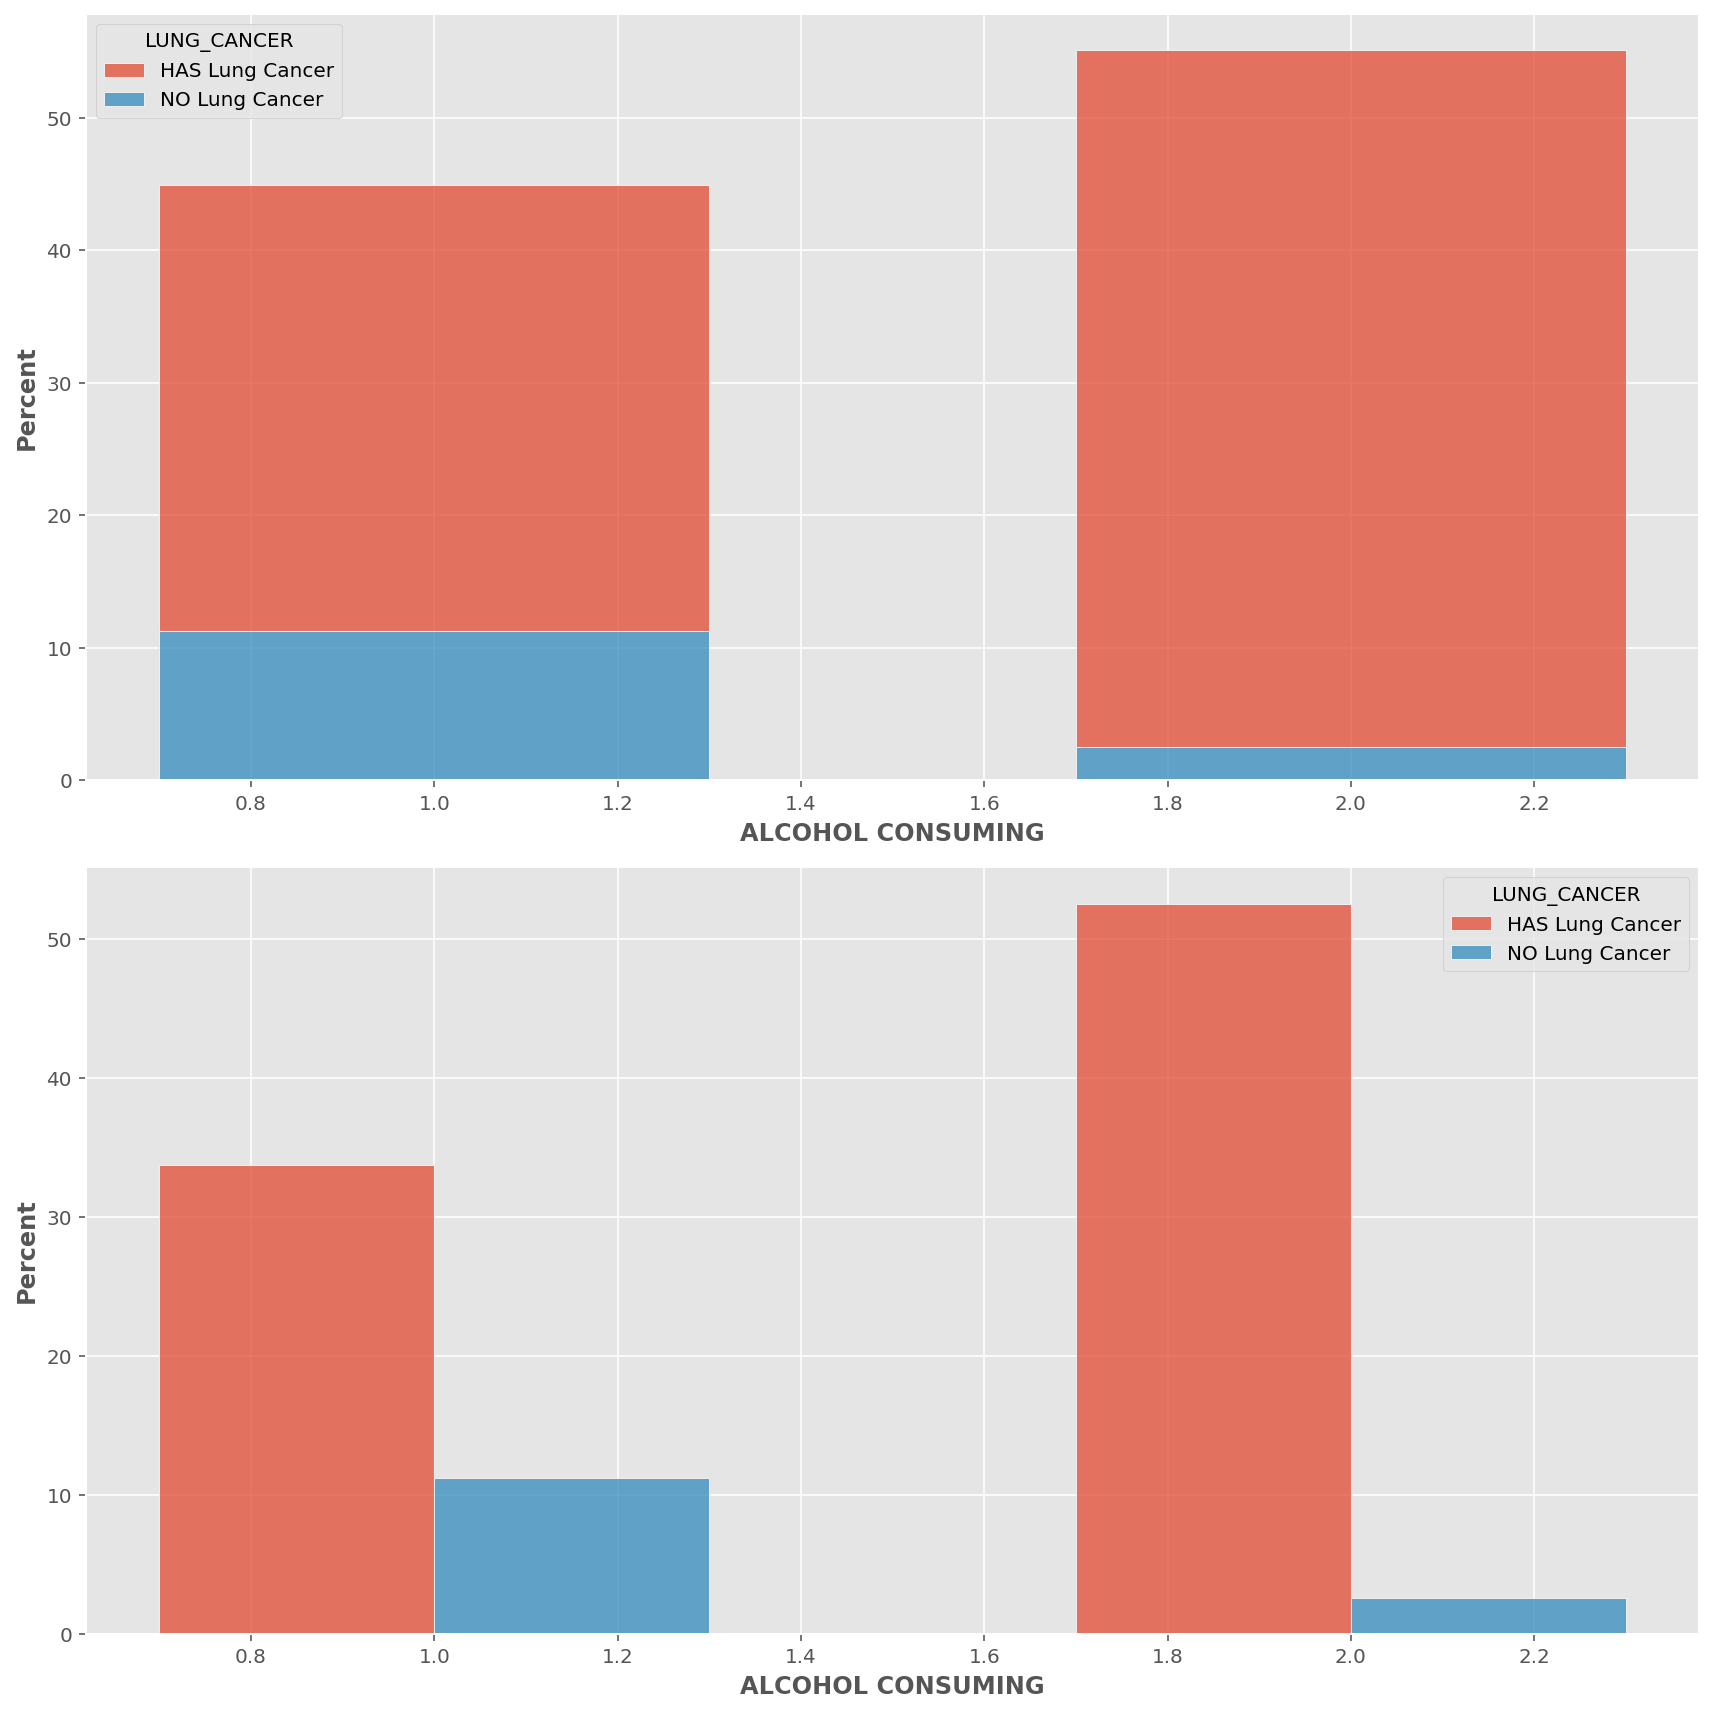

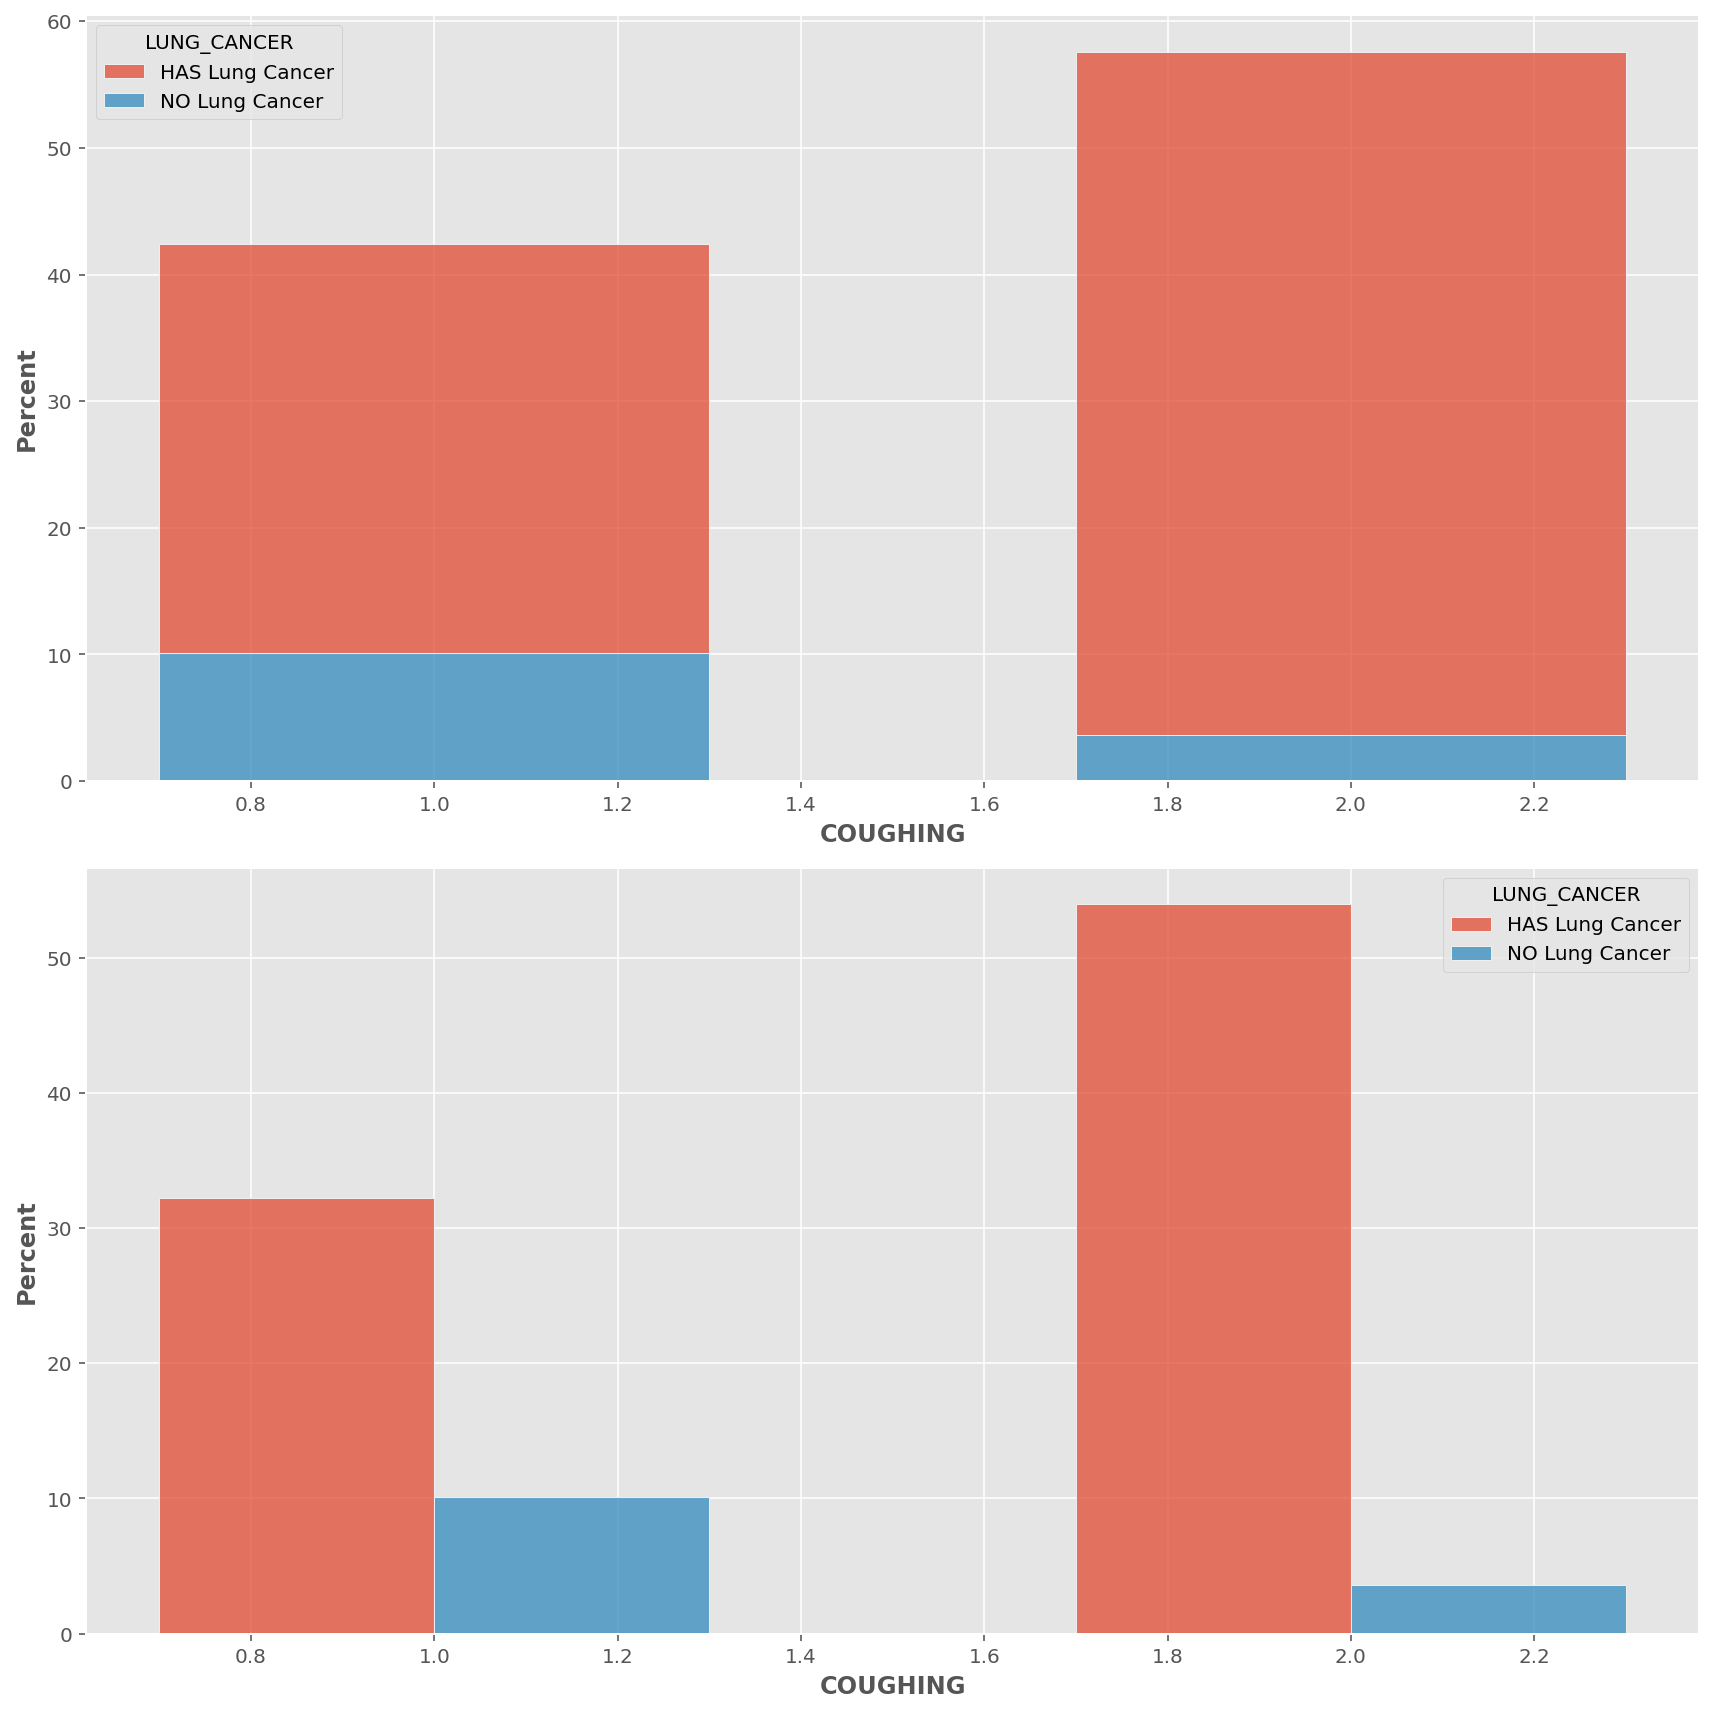

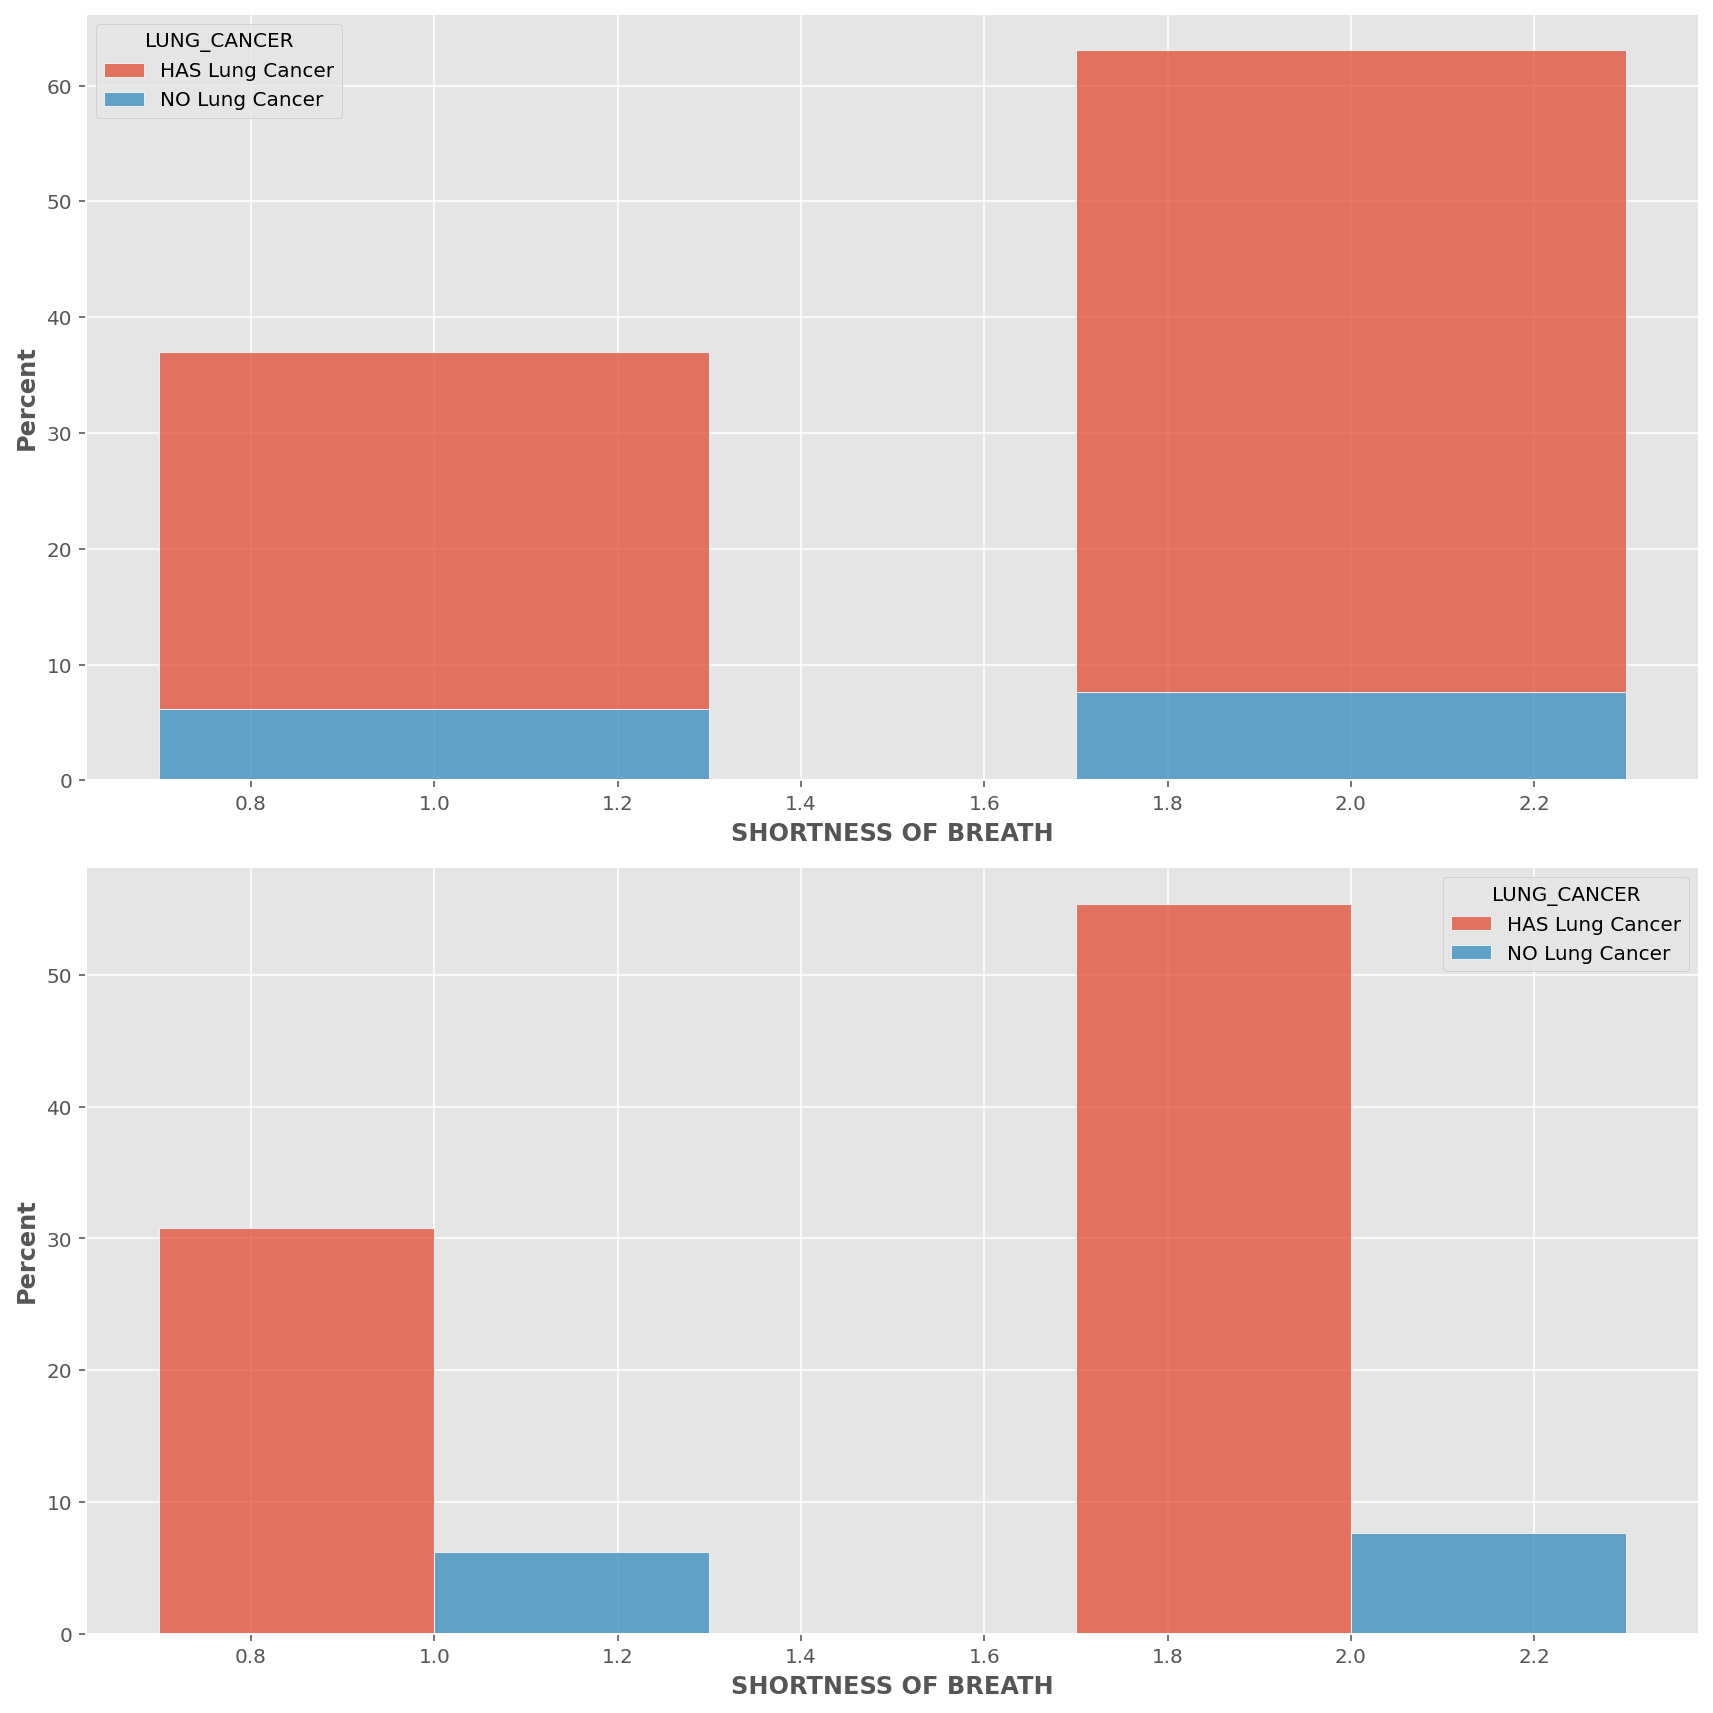

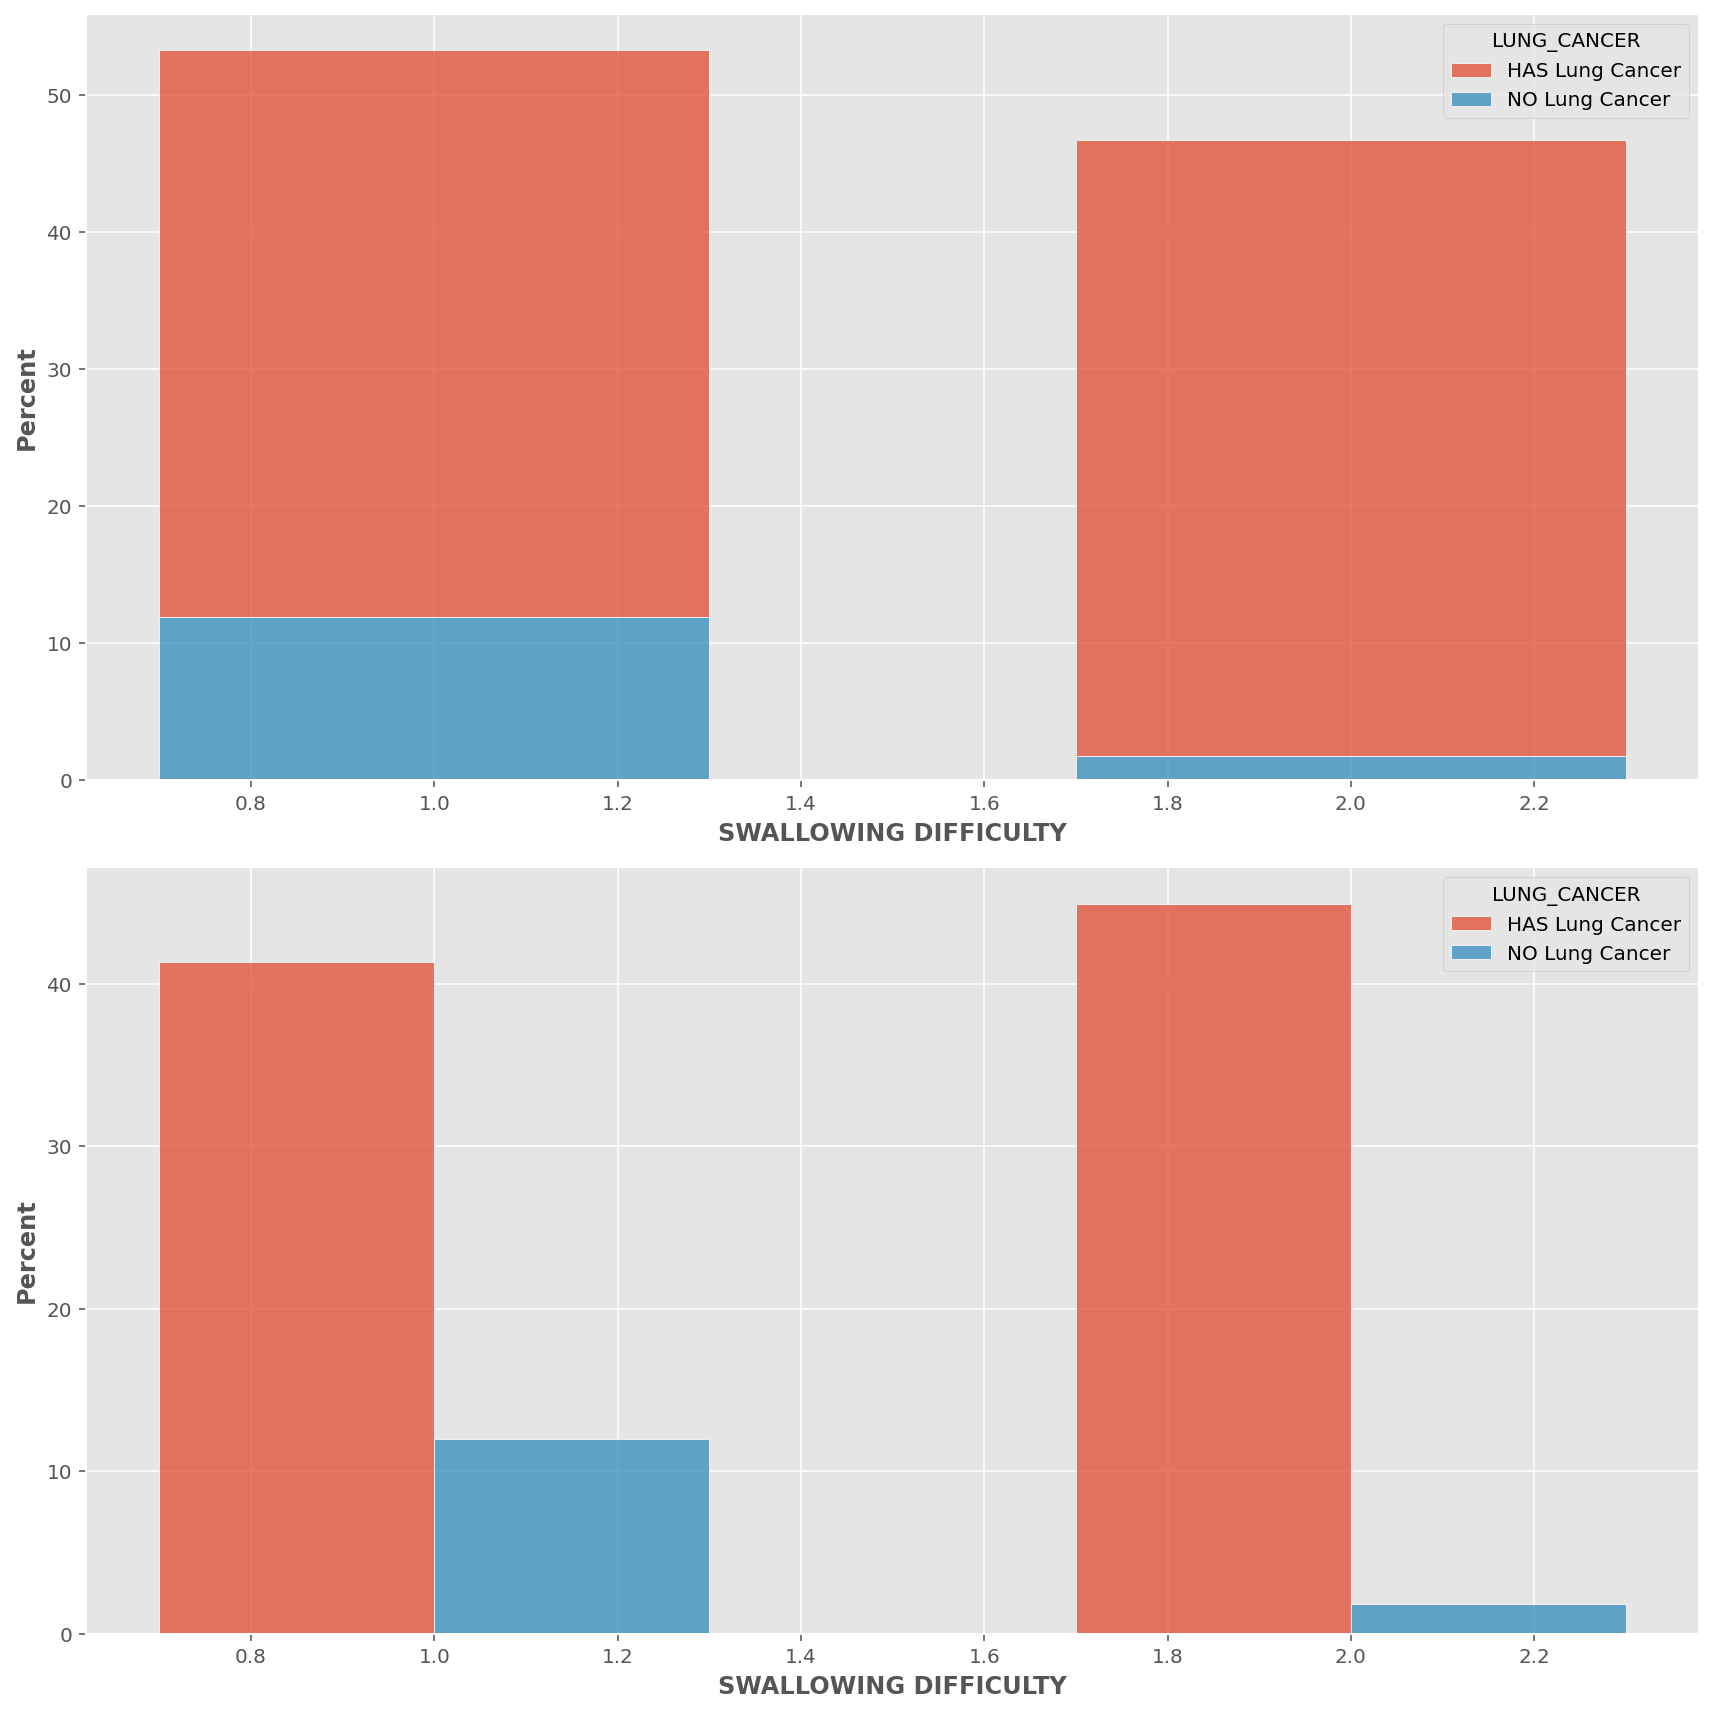

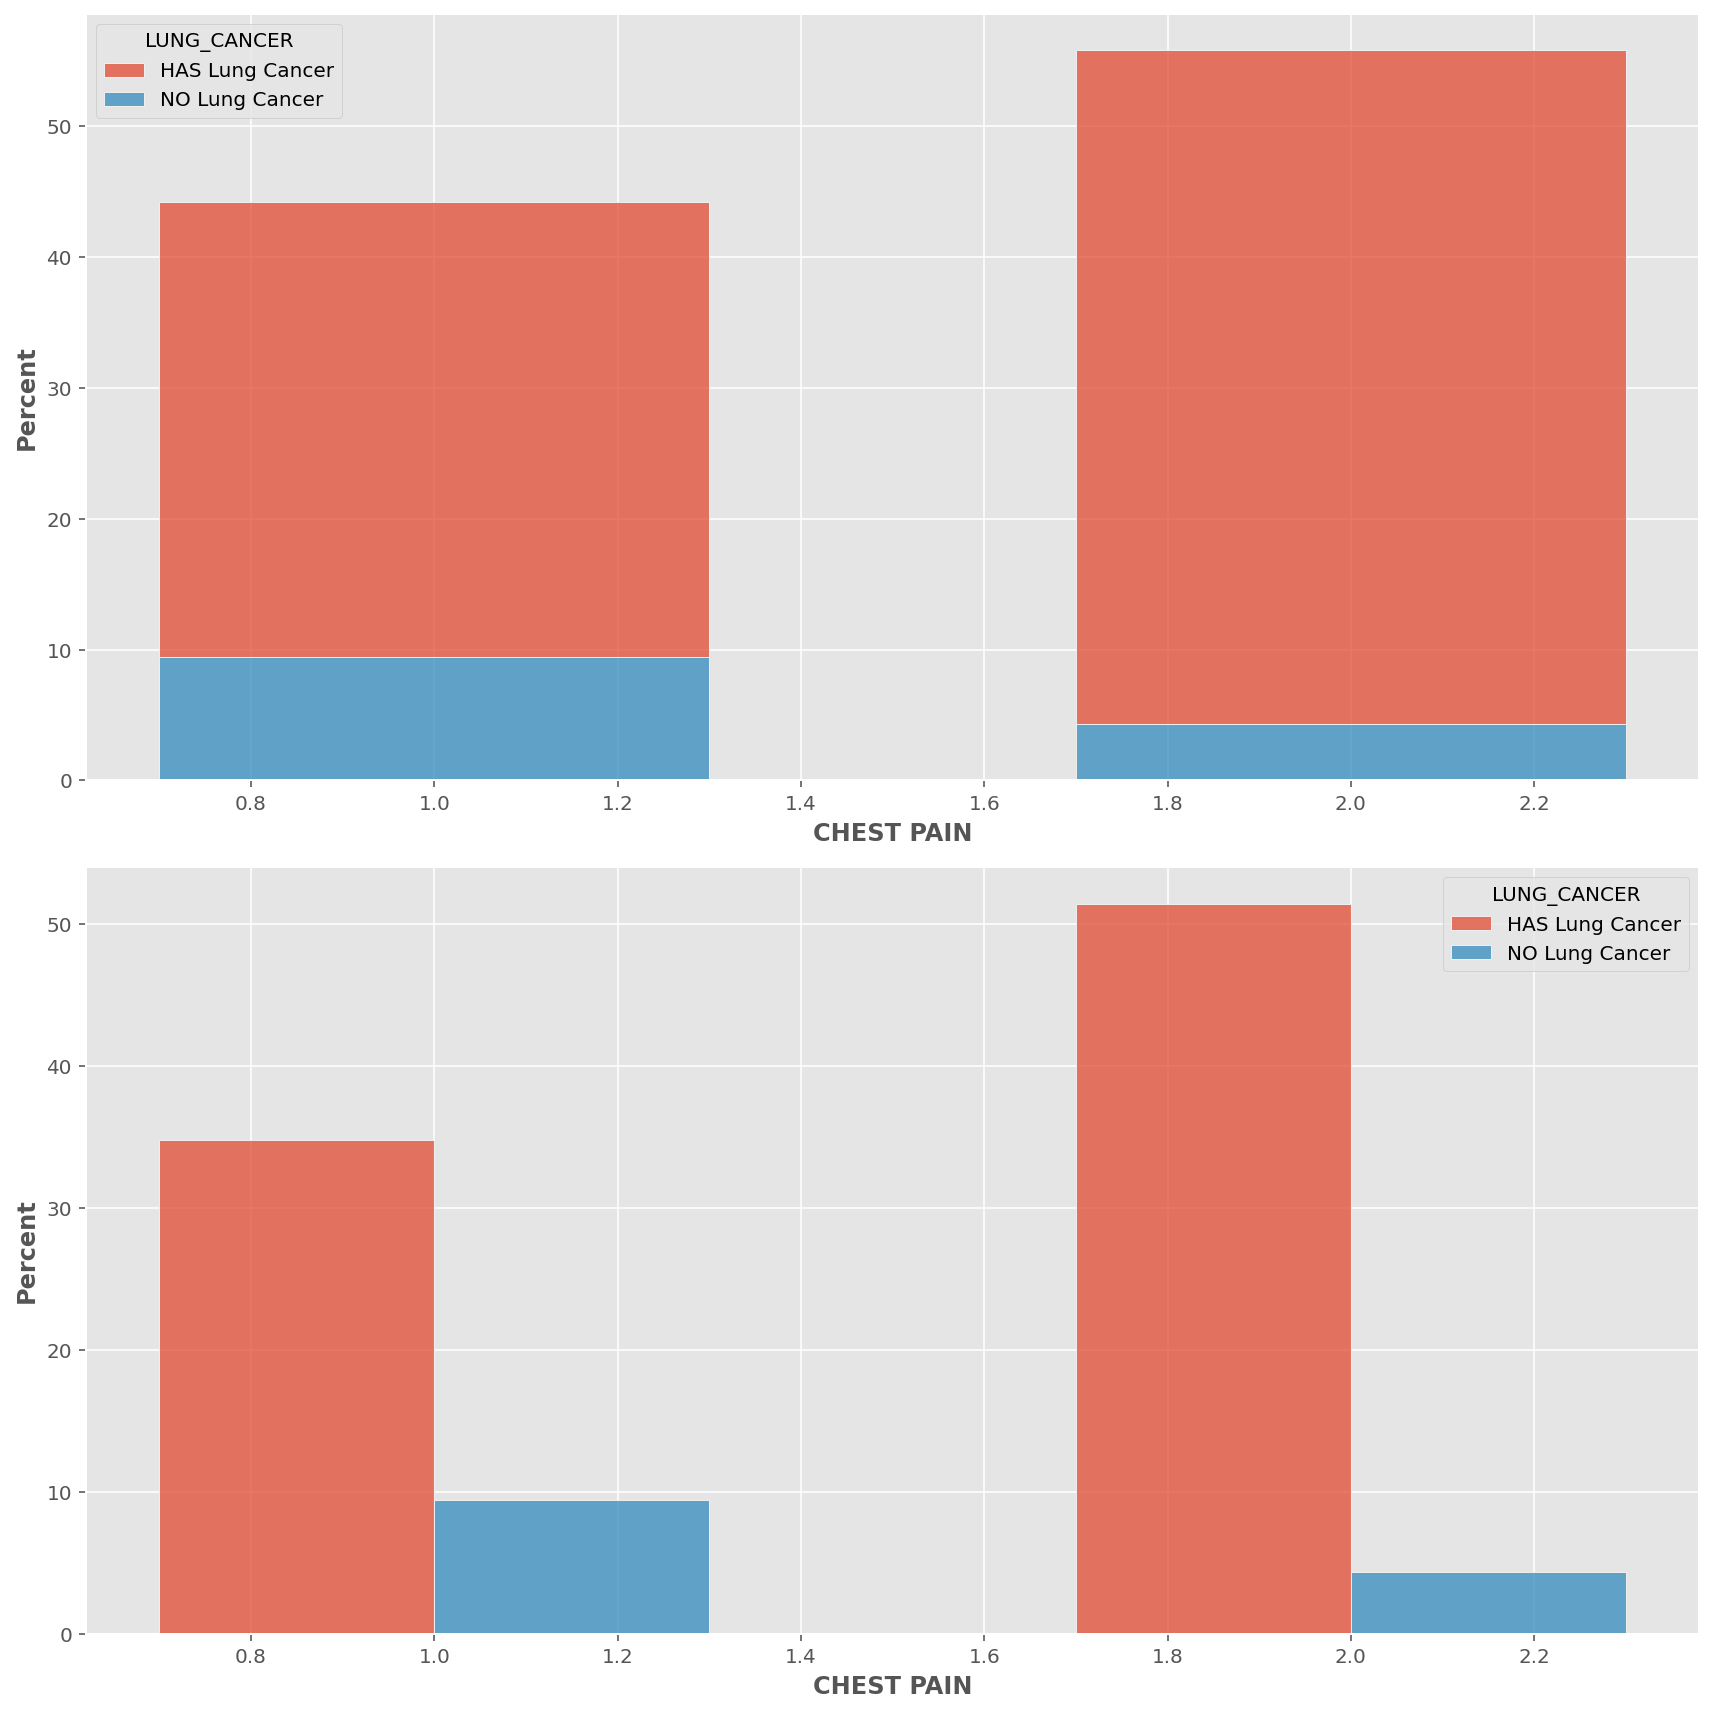

In [19]:
for col in cat_var[1:-1]:
    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12, 12))
    sns.histplot(data=plot_df, x= col, hue= "LUNG_CANCER", multiple="stack",stat= 'percent', shrink=.6, ax=ax1,discrete=True)
    sns.histplot(data=plot_df, x= col, hue= "LUNG_CANCER",multiple="dodge", shrink=.6, stat='percent' ,ax=ax2,discrete=True)

In [20]:
col=cat_var[-1]
print(f'{round(plot_df[col].value_counts()[0]/len(df)*100)} % of respondents have lung cancer')
print(f'{round(plot_df[col].value_counts()[1]/len(df)*100)} % of respondents do not have lung cancer')

86 % of respondents have lung cancer
14 % of respondents do not have lung cancer


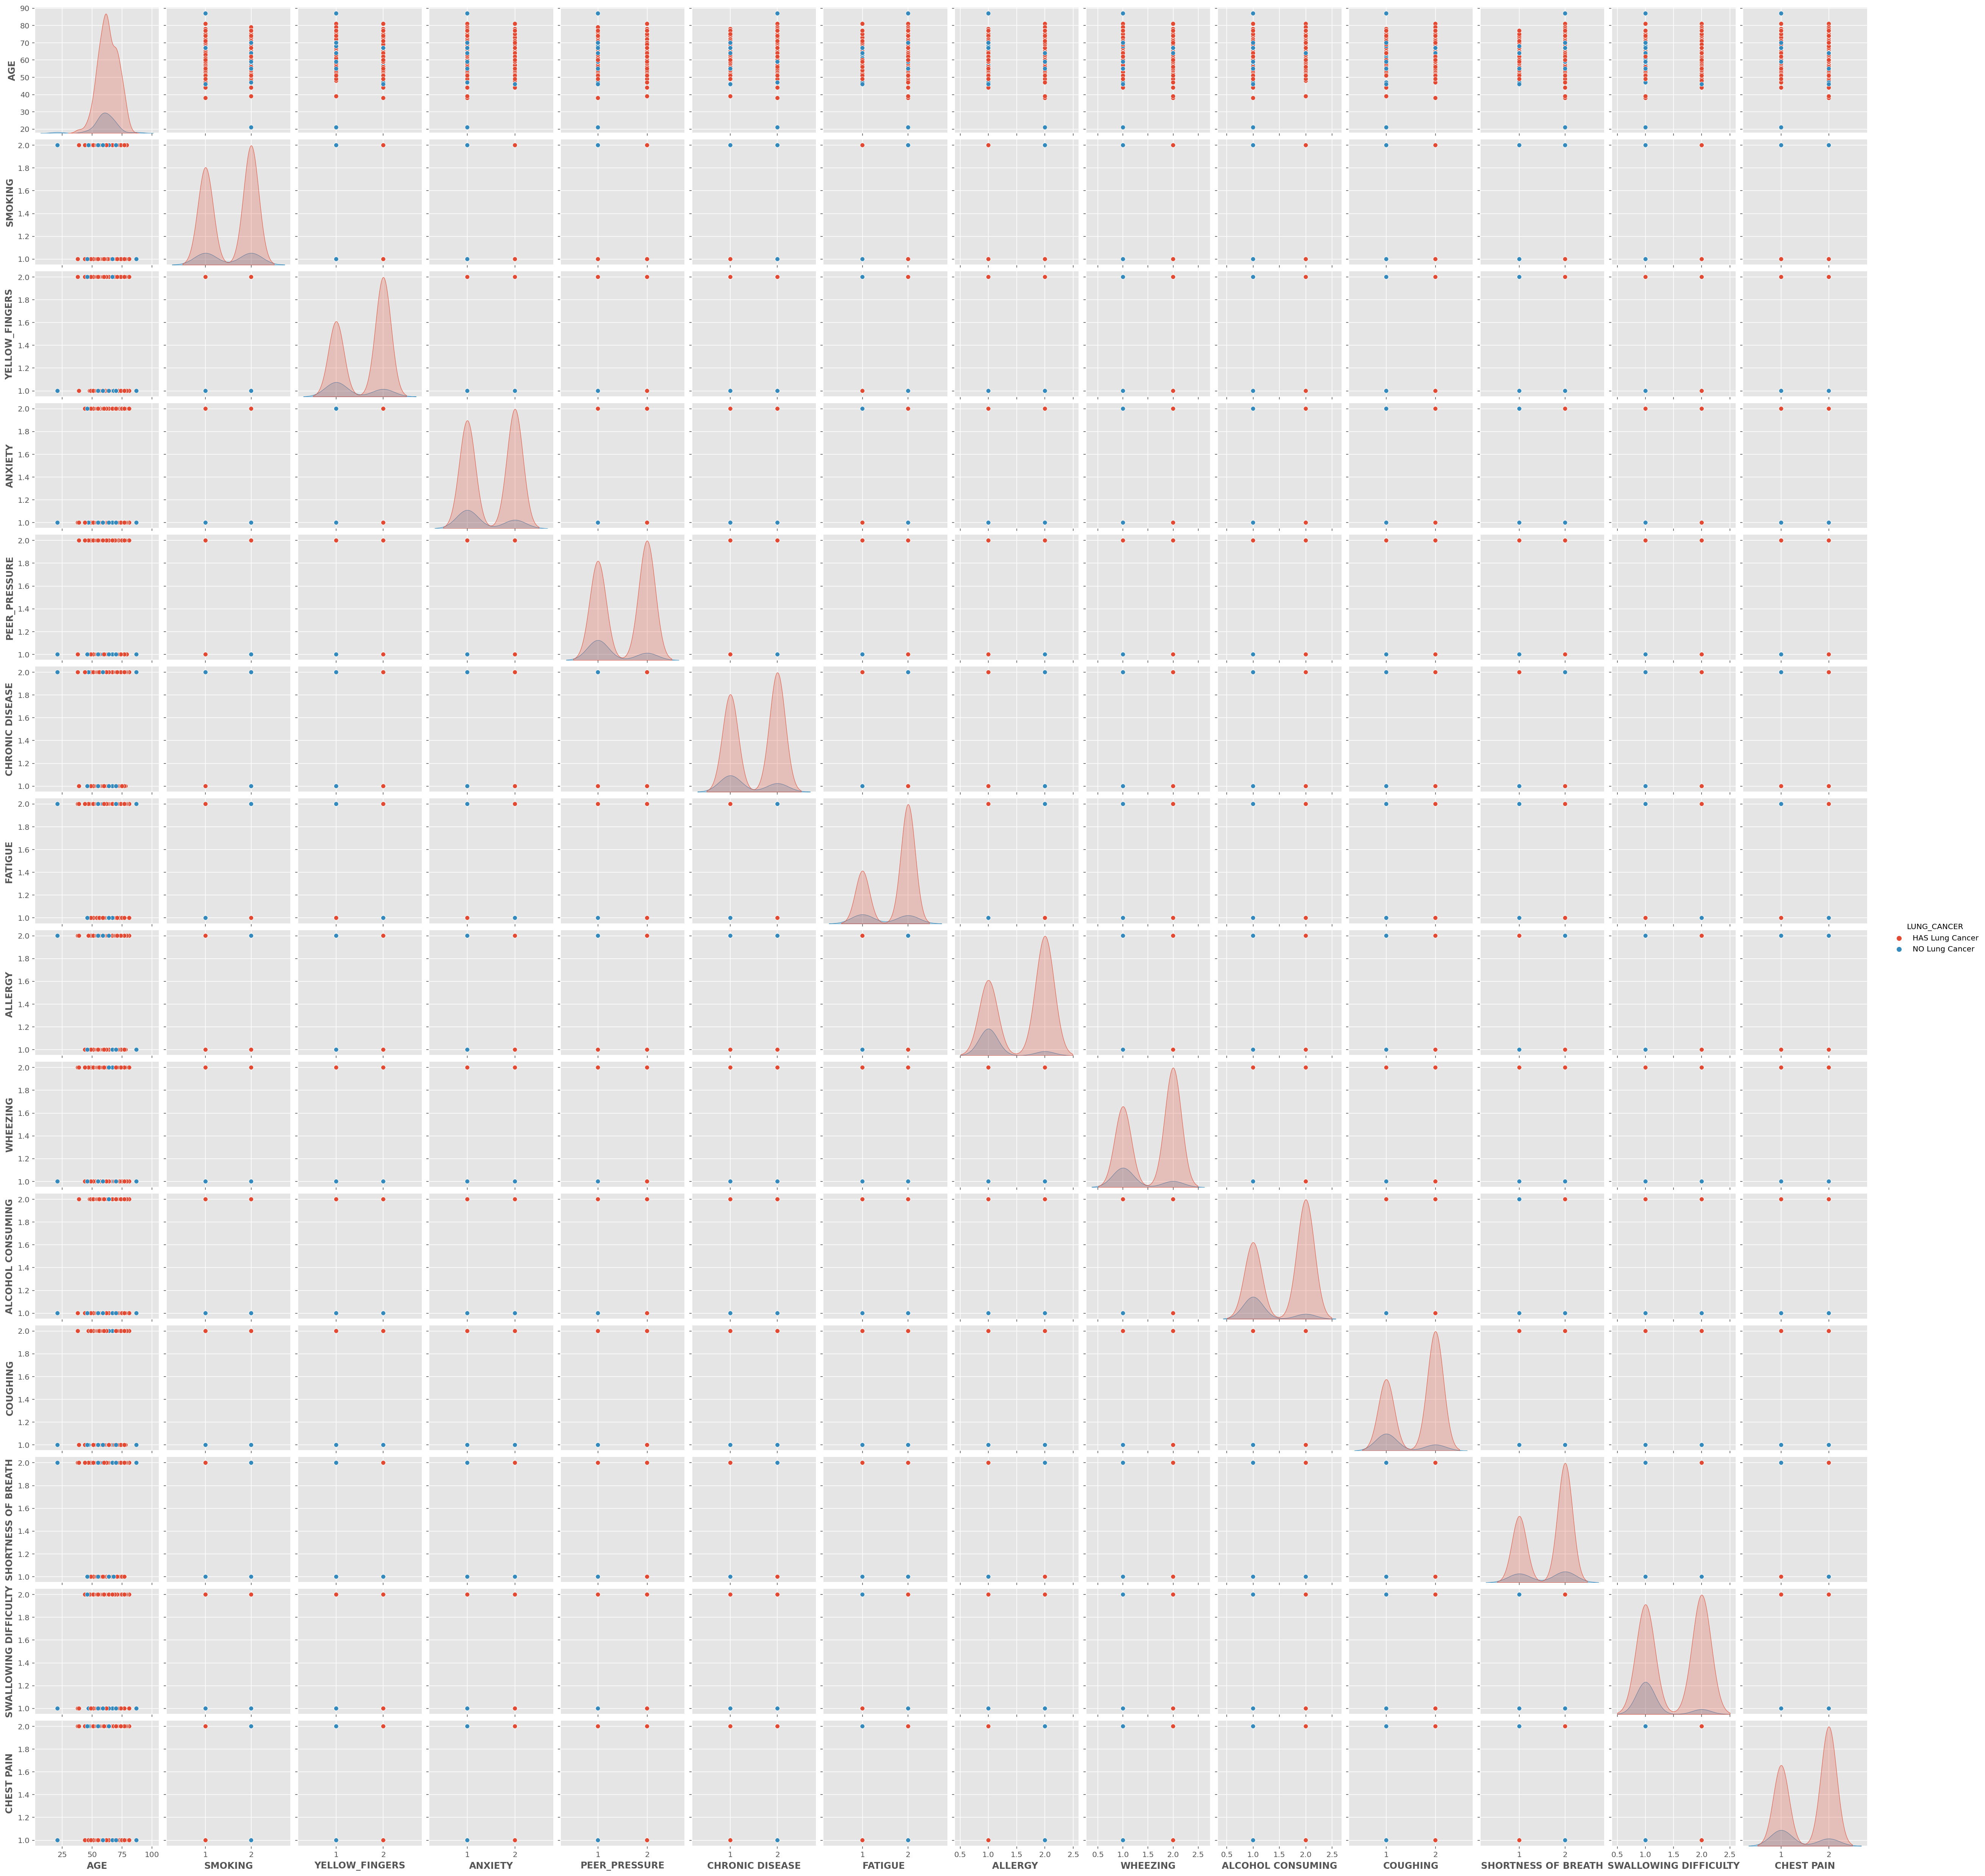

In [21]:
sns.pairplot(plot_df, hue="LUNG_CANCER")

Text(0.5, 1.0, 'Features correlation with LUNG CANCER')

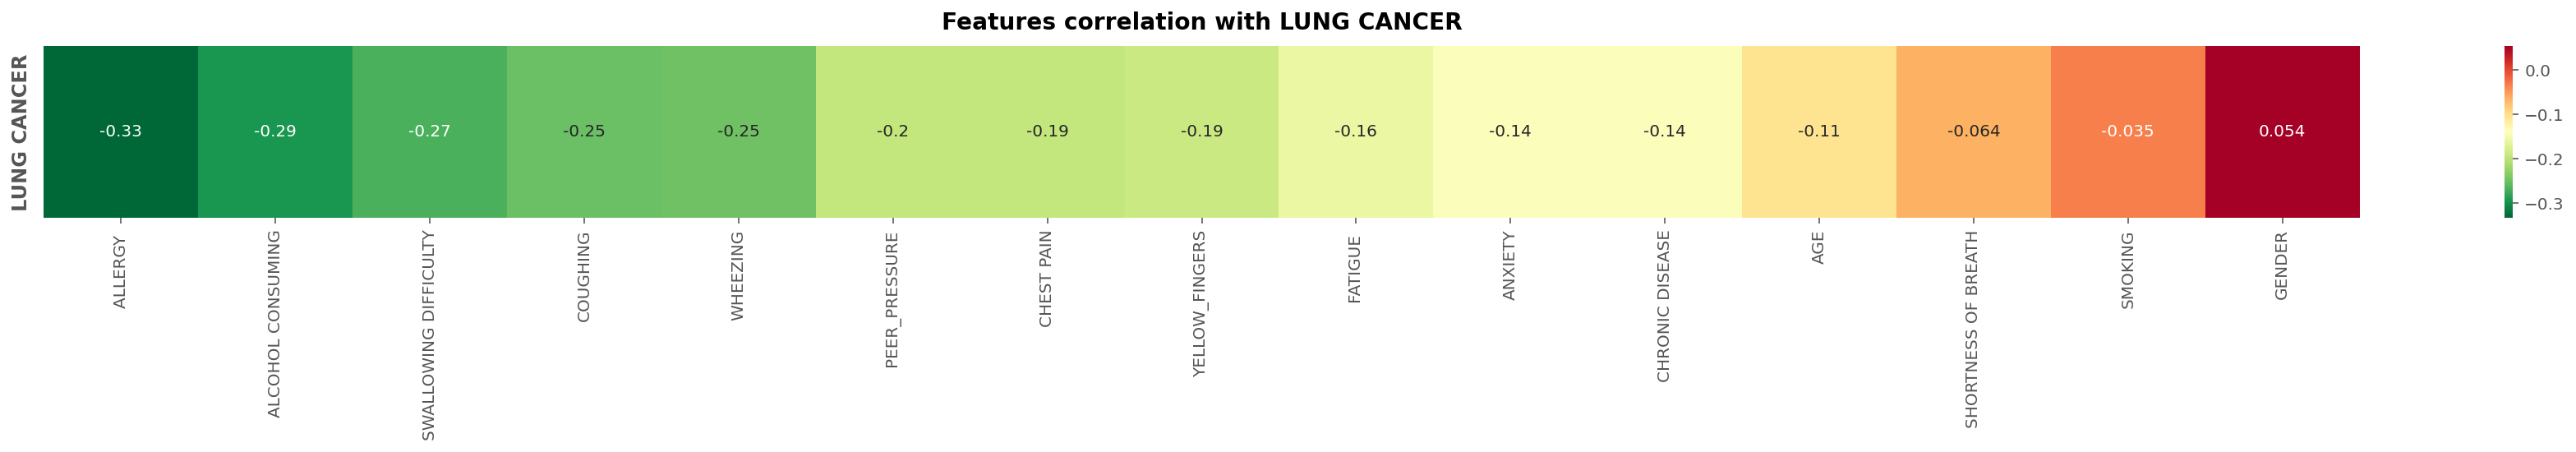

In [22]:
corr = df.loc[:,df.columns!='LUNG_CANCER'].corrwith(df.LUNG_CANCER).sort_values()
plt.figure(figsize=(25,2))
sns.heatmap(corr.to_frame().T,
            cmap='RdYlGn_r',
            annot=True,
)
plt.yticks([])
plt.ylabel('LUNG CANCER')
plt.title('Features correlation with LUNG CANCER')

In [23]:
# Model building

In [24]:
X = df.drop(['LUNG_CANCER'], axis=1)
y = df.LUNG_CANCER

In [25]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import make_scorer, precision_score, precision_recall_curve, plot_precision_recall_curve, plot_roc_curve, roc_auc_score, roc_curve, f1_score, accuracy_score, recall_score
from sklearn.metrics import plot_confusion_matrix, classification_report, confusion_matrix, accuracy_score

In [26]:
from imblearn.over_sampling import RandomOverSampler
X_over,y_over=RandomOverSampler().fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size=0.25, random_state=1)

In [27]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_train['AGE']=scaler.fit_transform(X_train[['AGE']])
X_test['AGE']=scaler.transform(X_test[['AGE']])
X_train.head()

,GENDER,AGE,SMOKING,YELLOW_FINGERS,ANXIETY,PEER_PRESSURE,CHRONIC DISEASE,FATIGUE,ALLERGY,WHEEZING,ALCOHOL CONSUMING,COUGHING,SHORTNESS OF BREATH,SWALLOWING DIFFICULTY,CHEST PAIN
81,2,-0.839729,2,2,2,2,2,2,1,1,1,1,2,2,1
41,1,0.082051,1,1,1,2,1,2,2,2,2,1,1,2,1
388,2,0.082051,1,1,1,1,2,2,1,1,1,1,2,1,1
351,2,0.901411,2,1,1,1,2,2,1,1,1,1,2,1,1
408,2,-0.532469,1,2,2,1,1,1,1,1,1,2,1,1,1


              precision    recall  f1-score   support

           1       1.00      0.92      0.96        59
           2       0.92      1.00      0.96        60

    accuracy                           0.96       119
   macro avg       0.96      0.96      0.96       119
weighted avg       0.96      0.96      0.96       119



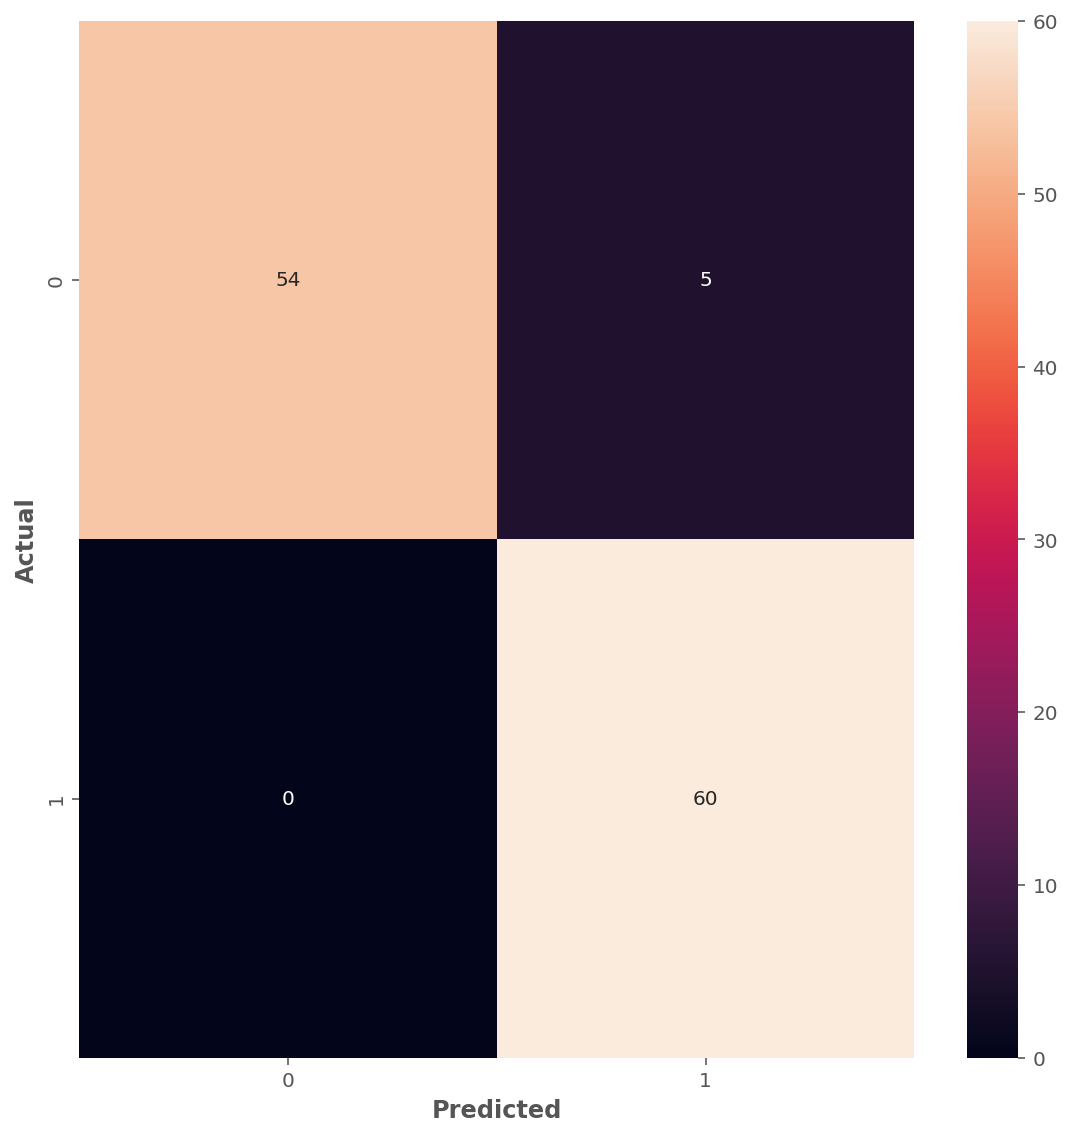

In [28]:

model = LGBMClassifier()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
confusion=confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(confusion,annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
print(classification_report(y_test,y_pred))

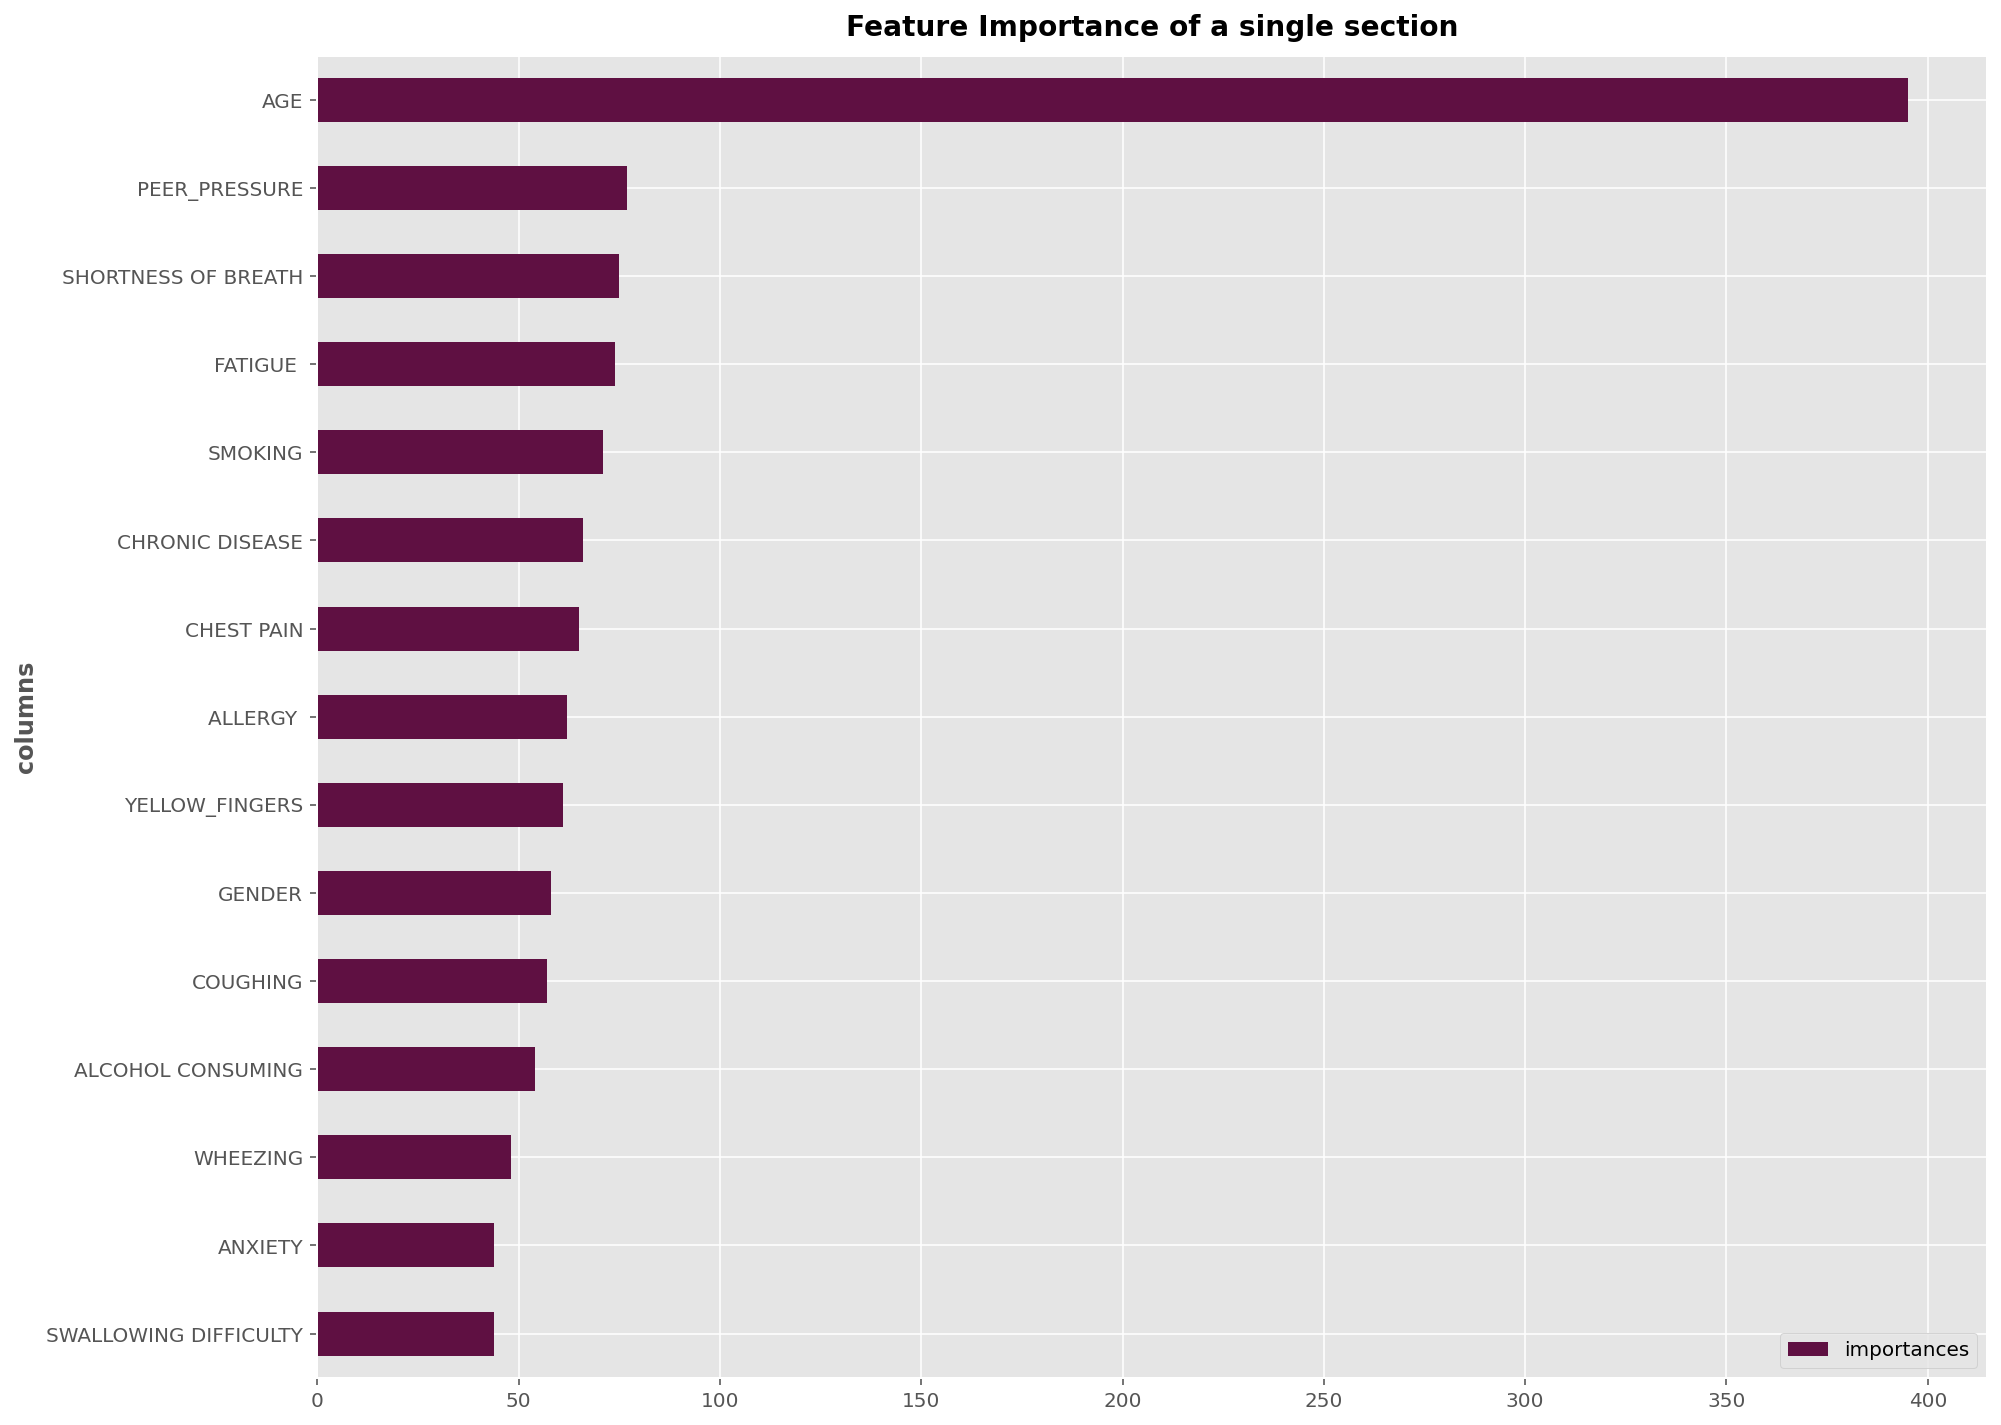

In [29]:
fi = (pd.DataFrame({'importances': model.feature_importances_, 
                        'columns': X_train.columns})
          .sort_values(['importances', 'columns'], ascending=[True, False])
          .plot(kind = 'barh', 
                x='columns', 
                y='importances', 
                figsize=(14, 10),
                color = '#5f1042'))
plt.title("Feature Importance of a single section")
plt.show()